#### Устанавливаем и импортируем библиотеки

In [1]:
%pip install pandas seaborn statsmodels requests ipython tqdm   scipy \
             tabulate matplotlib_venn -q 

%pip install matplotlib numpy numba  -q


# ------------------------------------------------------------------------------
# ⚠️ На платформе установлены устаревшие версии интерпретатора и библиотек
# Python 3.9 (Release Date: Oct. 5, 2020) - с 2022г. только обновления безопасности.  
# И matplotlib 3.3.4  (Выпущен: 28 янв. 2021 г.)  - нет даже bar_label ❗   
# bar_label появился в версии 3.4 - 26 марта 2021 г.
# ------------------------------------------------------------------------------
# ⚠️ "волшебная" комбинация версий чтобы победить "ад зависимостей" и заставить
# bar_label работать  
# %pip install matplotlib==3.7.0
# %pip install numpy==1.23.5
# %pip install numba==0.57.0
# ------------------------------------------------------------------------------
# на случай если будет недостаточно
# %pip install pandas==1.5.3
# %pip install seaborn==0.12.2
# %pip install scipy==1.10.1

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Импортируем библиотеки

# Работа с данными
import pandas as pd
import numpy as np
# from pandas.api.types import CategoricalDtype

# Визуализации
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
import seaborn as sns
from matplotlib_venn import venn2\

# стат
import scipy.stats as stats
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.power import TTestIndPower

# Вспомогательные импорты
from IPython.display import Markdown, display, HTML
import io
from tqdm import tqdm



# Пока не нужно
# ------------------------------------------------------------------------------
# ⚠️[GET RID OF THIS] функция кеширования данных 
# hp.download вместо pd.read_csv 
# import helpers as hp 

# import matplotlib.dates as mdates
# import matplotlib.colors as mcolors

# # ML (KMeans и нормализация признаков)
# from sklearn.cluster import KMeans
# from sklearn.preprocessing import StandardScaler 

# import IPython
# from typing import  Literal,  Dict
# import matplotlib.dates as mdates

# from matplotlib_venn import venn2


#### Определим полезные функции и настройки стилей форматирования

In [ ]:
#-----------------------------------------------------------------------------
#🔸Стили
#-----------------------------------------------------------------------------

# Зададим произвольные стили и настройки форматирования 
display(HTML("""<style>.output_area{max-height: none !important;}
             h1{color:#D14D41;}h2{color:#DA702C;}h3{color:#D0A215;}
             h4{color:#879A39;}h5{color:#3AA99F;}h6{color:#4385BE;}
             </style>"""))

# набор цветов, чтобы сделать графики **визуально интересней**
pal = [
    '#C9495E',  '#50C2E5', '#38A86F',  '#D466A0', 
    "#956BBE",  "#0B8C9E", "#EAD38C",  '#17BECF'
]

# цвета групп, чтобы была **консистентность** стилей групп
color_A, color_B = '#87ceeb', '#ffa07a'


# палитра для тепловой карты
my_cmap = mcolors.LinearSegmentedColormap\
        .from_list('green_red', ['#FF3333', '#FFFF66', '#4C9900'], N=100)
        
# вынесем параметры по умолчанию дле тепловых карт
heatmap_pct_params = {"fmt":'.0%',  "annot":True, "linewidth":0.5, 
                          "annot_kws":{'size':11}, "cmap":my_cmap}        
heatmap_val_params = {"fmt":'.0f',  "annot":True, "linewidth":0.5, 
                          "annot_kws":{'size':11}, "cmap":my_cmap}       
    

# полезные функции
#-----------------------------------------------------------------------------
# 🔸 Предобработка
#-----------------------------------------------------------------------------

# Расширенная информация о данных
# В отличии от info выводит процент нулей. **Удобно** чтобы не прикидывать в 
# уме доли. Решает проблему: Сколько там нулей? 4.73% или 8.19%?🤔 Это уже 
# достаточно много чтобы не игнорировать или еще нет? 🤔  

def extended_info(df):
    buf = io.StringIO()
    df.info(buf=buf)
    info_lines = buf.getvalue().splitlines()
    rn = info_lines[1].split()[1] # rows number
    
    cols = ['Name',  'Non-Null', 'Null', 'Null share', 'Dtype']

    data = [
        [' '.join(x[1:-3]), x[-3], int(rn) - int(x[-3]), 
         f'{round((int(rn) - int(x[-3]))*100 / int(rn) , 2)}%',  x[-1]]
        for row in info_lines[5:-2]
        for x in [row.split()]
    ]
    
    meta = [
        [f'**{x[0]}**', f'**{x[1]}**'] + ['']*(len(cols)-2) 
        for row  in info_lines[-2:] 
        for x  in [row.split(': ')]
    ]
    
    data += meta
    return Markdown(pd.DataFrame(data, columns=cols).to_markdown())

# ------------------------------------------------------------------------------
# простая проверка на наличие явных дубликатов
# обертка над стандартным функционалом - просто захотелось
def check_exp_dups(data, cols_subset= None):
    # проверим на наличие полных дубликатов
    full_dups = data.duplicated().sum()
    print(f"Количество явных дубликатов по всем полям: {full_dups.sum()}")

    #  проверим на наличие дубликатов по отдельным столбцам
    if cols_subset:
        subset_dups = data.duplicated(subset=cols_subset)
        print(f"По заданному набору полей: {subset_dups.sum()}")
        print(cols_subset)


# ------------------------------------------------------------------------------
# уникальные значения категориальных признаков
# Функция `get_df_unique_values` - уникальные значения категориальных признаков
# ф. решает проблему неявного дублирования данных. 
# - Пример: вывели уники в поле город ВРУЧНУЮ, видим что есть неявные дубликаты  
#     Санкт-Петербург  
#     Санкт Петербург (без дефиса)  
#     Санкт-Петербуг (опечатка)  
# 
#  Функция же автоматизирует этот процесс
# - ввел ВСЕ кат. столбцы - получил на выходе уникальные значения 
# **сразу по ВСЕМ столбцам в одной таблице**.

def get_df_unique_values(df, cols=None, row_count=20):
    new_cols = dict()
    
    if cols is None:
        cols = df.columns.tolist()
    
    for col in cols:
        try: 
            u_vals = sorted(df[col].unique())
        except TypeError:
            u_vals = df[col].unique()
        
        if len(u_vals) > row_count:
            for i in range(0, len(u_vals), row_count):
                col_name = f"{col}_{i // row_count + 1}"  
                
                chnk = pd.Series(u_vals[i:i + row_count]).reset_index(drop=True)
                padded = chnk.reindex(range(row_count), fill_value='')
                
                new_cols[col_name] = padded
        else:
            padded = pd.Series(u_vals).reindex(range(row_count), fill_value='')
            new_cols[col] = padded.reset_index(drop=True)
            
    new_df = pd.DataFrame(new_cols)
    return new_df



#-----------------------------------------------------------------------------
# 🔸 визуализации
#-----------------------------------------------------------------------------

# столбчатая диаграмма для сравнения размеров групп (control и test).
def plot_group_comparison_bar( data: pd.Series, title: str, 
                              ylabel: str, fig_size: tuple = (8,6), 
                              colors: tuple = ('#87ceeb', '#ffa07a')
):
        
    control_val = data.iloc[0]
    test_val = data.iloc[1]
    
    # считаем процентную разницу
    diff_percent = (test_val - control_val) / control_val * 100
    
    # --- Построение графика ---
    plt.figure(figsize=fig_size)
    bars = plt.bar(data.index, data.values, color=colors, width=0.4)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel('Группа')
    
    
    # 1. Основные метки (абсолютные значения)
    plt.bar_label(bars, fmt='%.0f', padding=3)
    
    # 2. Метка с процентной разницей для тестовой группы
    #    (располагаем ее чуть выше основной метки)
    y_pos = bars[1].get_height()
    offset = bars[1].get_height() * 0.07 # динамический отступ
    
    plt.text(
        x=bars[1].get_x() + bars[1].get_width() / 2, # по центру столбца
        y=y_pos + offset,                            # чуть выше столбца
        s=f'({diff_percent:+.1f}%)',                 # текст метки
        ha='center',
        color='red' if diff_percent < 0 else 'green'
    )
    
    # добавляем немного места сверху
    plt.ylim(0, max(control_val, test_val) * 1.2)
    # отодвигаем столбцы от краев
    plt.xlim(-0.5, 1.5)
    plt.show()

### 1. Предобработка данных

> **Загрузка данных**
>
> Исходные данные были загружены из следующих CSV-файлов:  
> 'orders.csv', 'sessions.csv', 'users.csv', 'events.csv', 'campaign_costs.csv'  
> и сохранены в словарь `ds` с ключами `orders`, `sessions`, ...
>
> В процессе загрузки столбцы с датами были сразу приведены к формату `datetime`.
>
> ⚠️*Примечание: в соответствии с политикой конфиденциальности, код загрузки и сами файлы данных удалены из публичной версии проекта*

In [ ]:
# Загрузим датасеты и сразу преобразуем даты используя аргумент parse_dates
# ...

# Выводим расширенную информацию о данных
for name, dataset in ds.items():
    display(Markdown(f'#### {name}'))
    display(extended_info(dataset))
    display(dataset.head())
    

#### orders

|    | Name             | Non-Null                                               | Null   | Null share   | Dtype          |
|---:|:-----------------|:-------------------------------------------------------|:-------|:-------------|:---------------|
|  0 | order_id         | 31357                                                  | 0      | 0.0%         | int64          |
|  1 | user_id          | 31357                                                  | 0      | 0.0%         | int64          |
|  2 | order_date       | 31357                                                  | 0      | 0.0%         | datetime64[ns] |
|  3 | product_name     | 31357                                                  | 0      | 0.0%         | object         |
|  4 | quantity         | 31357                                                  | 0      | 0.0%         | int64          |
|  5 | unit_price       | 31357                                                  | 0      | 0.0%         | float64        |
|  6 | total_price      | 31357                                                  | 0      | 0.0%         | float64        |
|  7 | category_name    | 31357                                                  | 0      | 0.0%         | object         |
|  8 | order_week       | 31357                                                  | 0      | 0.0%         | datetime64[ns] |
|  9 | order_month      | 31357                                                  | 0      | 0.0%         | datetime64[ns] |
| 10 | **dtypes**       | **datetime64[ns](3), float64(2), int64(3), object(2)** |        |              |                |
| 11 | **memory usage** | **2.4+ MB**                                            |        |              |                |

,order_id,user_id,order_date,product_name,quantity,unit_price,total_price,category_name,order_week,order_month
0,1,3,2024-01-19 01:52:52,Шуруповерт,2,5539.13,11078.26,Инструменты и садовый инвентарь,2024-01-15,2024-01-01
1,2,3,2024-01-19 01:52:52,Молоток слесарный,1,11340.38,11340.38,Инструменты и садовый инвентарь,2024-01-15,2024-01-01
2,3,3,2024-01-19 01:52:52,Секатор садовый,2,10892.09,21784.18,Инструменты и садовый инвентарь,2024-01-15,2024-01-01
3,4,3,2024-01-25 13:59:38,Шуруповерт,2,5539.13,11078.26,Инструменты и садовый инвентарь,2024-01-22,2024-01-01
4,5,3,2024-01-25 13:59:38,Чай черный,1,2099.59,2099.59,Продукты питания,2024-01-22,2024-01-01


#### campaign_costs

|    | Name             | Non-Null                                               | Null   | Null share   | Dtype          |
|---:|:-----------------|:-------------------------------------------------------|:-------|:-------------|:---------------|
|  0 | Unnamed: 0       | 88                                                     | 0      | 0.0%         | int64          |
|  1 | acq_channel      | 88                                                     | 0      | 0.0%         | object         |
|  2 | spend_month      | 88                                                     | 0      | 0.0%         | datetime64[ns] |
|  3 | budget           | 88                                                     | 0      | 0.0%         | float64        |
|  4 | **dtypes**       | **datetime64[ns](1), float64(1), int64(1), object(1)** |        |              |                |
|  5 | **memory usage** | **2.9+ KB**                                            |        |              |                |

,Unnamed: 0,acq_channel,spend_month,budget
0,0,Affiliate,2024-01-01,179343.3875
1,1,Affiliate,2024-02-01,175488.4875
2,2,Affiliate,2024-03-01,164543.4750
3,3,Affiliate,2024-04-01,186869.9750
4,4,Affiliate,2024-05-01,166443.7750


#### sessions

|    | Name             | Non-Null                                    | Null   | Null share   | Dtype          |
|---:|:-----------------|:--------------------------------------------|:-------|:-------------|:---------------|
|  0 | session_id       | 119535                                      | 0      | 0.0%         | int64          |
|  1 | user_id          | 119535                                      | 0      | 0.0%         | int64          |
|  2 | session_start    | 119535                                      | 0      | 0.0%         | datetime64[ns] |
|  3 | os               | 119535                                      | 0      | 0.0%         | object         |
|  4 | device           | 119535                                      | 0      | 0.0%         | object         |
|  5 | region           | 119535                                      | 0      | 0.0%         | object         |
|  6 | browser          | 119535                                      | 0      | 0.0%         | object         |
|  7 | country          | 119535                                      | 0      | 0.0%         | object         |
|  8 | entry_path       | 119535                                      | 0      | 0.0%         | object         |
|  9 | path_start       | 119535                                      | 0      | 0.0%         | object         |
| 10 | utm_source       | 119535                                      | 0      | 0.0%         | object         |
| 11 | screen_size      | 119535                                      | 0      | 0.0%         | object         |
| 12 | scroll_depth     | 119535                                      | 0      | 0.0%         | int64          |
| 13 | user_segment     | 119535                                      | 0      | 0.0%         | object         |
| 14 | utm_campaign_id  | 119535                                      | 0      | 0.0%         | int64          |
| 15 | session_week     | 119535                                      | 0      | 0.0%         | datetime64[ns] |
| 16 | session_month    | 119535                                      | 0      | 0.0%         | datetime64[ns] |
| 17 | **dtypes**       | **datetime64[ns](3), int64(4), object(10)** |        |              |                |
| 18 | **memory usage** | **15.5+ MB**                                |        |              |                |

,session_id,user_id,session_start,os,device,region,browser,country,entry_path,path_start,utm_source,screen_size,scroll_depth,user_segment,utm_campaign_id,session_week,session_month
0,705,160,2024-01-12 02:30:37,Windows,mobile,Москва,Safari,Россия,/home,/recommend/10,unknown,768x1024,51,regular,14,2024-01-08,2024-01-01
1,706,160,2024-01-10 06:04:41,Windows,mobile,Москва,Safari,Россия,/home,/sale/2,unknown,375x667,71,regular,14,2024-01-08,2024-01-01
2,707,160,2024-01-23 03:31:16,Windows,mobile,Москва,Safari,Россия,/checkout,/click/20,unknown,768x1024,84,regular,14,2024-01-22,2024-01-01
3,708,160,2024-01-18 13:43:45,Windows,mobile,Москва,Safari,Россия,/category,/campaign/20,unknown,768x1024,20,regular,14,2024-01-15,2024-01-01
4,709,160,2024-01-21 01:09:58,Windows,mobile,Москва,Safari,Россия,/promo,/sale/3,unknown,1366x768,88,regular,14,2024-01-15,2024-01-01


#### users

|    | Name              | Non-Null                                   | Null   | Null share   | Dtype          |
|---:|:------------------|:-------------------------------------------|:-------|:-------------|:---------------|
|  0 | user_id           | 44151                                      | 0      | 0.0%         | int64          |
|  1 | registration_date | 44151                                      | 0      | 0.0%         | datetime64[ns] |
|  2 | os                | 44151                                      | 0      | 0.0%         | object         |
|  3 | age               | 44151                                      | 0      | 0.0%         | int64          |
|  4 | device            | 44151                                      | 0      | 0.0%         | object         |
|  5 | gender            | 44151                                      | 0      | 0.0%         | object         |
|  6 | region            | 44151                                      | 0      | 0.0%         | object         |
|  7 | browser           | 44151                                      | 0      | 0.0%         | object         |
|  8 | country           | 44151                                      | 0      | 0.0%         | object         |
|  9 | acq_channel       | 44151                                      | 0      | 0.0%         | object         |
| 10 | campaign_id       | 44151                                      | 0      | 0.0%         | int64          |
| 11 | user_segment      | 44151                                      | 0      | 0.0%         | object         |
| 12 | buyer_segment     | 44151                                      | 0      | 0.0%         | object         |
| 13 | cohort_week       | 44151                                      | 0      | 0.0%         | datetime64[ns] |
| 14 | cohort_month      | 44151                                      | 0      | 0.0%         | datetime64[ns] |
| 15 | **dtypes**        | **datetime64[ns](3), int64(3), object(9)** |        |              |                |
| 16 | **memory usage**  | **5.1+ MB**                                |        |              |                |

,user_id,registration_date,os,age,device,gender,region,browser,country,acq_channel,campaign_id,user_segment,buyer_segment,cohort_week,cohort_month
0,1,2024-01-01 00:47:00,macOS,35,desktop,M,Москва,Firefox,Россия,Google Ads,33,спящий,regular,2024-01-01,2024-01-01
1,2,2024-01-01 19:01:00,iOS,53,desktop,M,Москва,Edge,Россия,Email Marketing,18,спящий,rare,2024-01-01,2024-01-01
2,3,2024-01-01 04:13:00,Android,66,mobile,F,Санкт-Петербург,Chrome,Россия,Google Ads,6,VIP,regular,2024-01-01,2024-01-01
3,4,2024-01-01 17:18:00,Windows,58,desktop,M,Краснодар,Firefox,Россия,Affiliate,25,новичок,one_time,2024-01-01,2024-01-01
4,5,2024-01-01 08:29:00,Android,58,desktop,F,Другие регионы,Edge,Россия,Google Ads,18,новичок,regular,2024-01-01,2024-01-01


#### events

|    | Name             | Non-Null                                   | Null   | Null share   | Dtype          |
|---:|:-----------------|:-------------------------------------------|:-------|:-------------|:---------------|
|  0 | event_id         | 785859                                     | 0      | 0.0%         | int64          |
|  1 | session_id       | 785859                                     | 0      | 0.0%         | int64          |
|  2 | user_id          | 785859                                     | 0      | 0.0%         | int64          |
|  3 | event_date       | 785859                                     | 0      | 0.0%         | datetime64[ns] |
|  4 | event_type       | 785859                                     | 0      | 0.0%         | object         |
|  5 | os               | 785859                                     | 0      | 0.0%         | object         |
|  6 | device           | 785859                                     | 0      | 0.0%         | object         |
|  7 | event_index      | 785859                                     | 0      | 0.0%         | int64          |
|  8 | user_segment     | 785859                                     | 0      | 0.0%         | object         |
|  9 | product_name     | 385740                                     | 400119 | 50.91%       | object         |
| 10 | event_week       | 785859                                     | 0      | 0.0%         | datetime64[ns] |
| 11 | event_month      | 785859                                     | 0      | 0.0%         | datetime64[ns] |
| 12 | **dtypes**       | **datetime64[ns](3), int64(4), object(5)** |        |              |                |
| 13 | **memory usage** | **71.9+ MB**                               |        |              |                |

,event_id,session_id,user_id,event_date,event_type,os,device,event_index,user_segment,product_name,event_week,event_month
0,3132,479,100,2024-01-01 15:23:56,page_view,iOS,mobile,1,regular,NaN,2024-01-01,2024-01-01
1,3133,479,100,2024-01-01 15:24:01,product_view,iOS,mobile,2,regular,Шорты для тренировок,2024-01-01,2024-01-01
2,3134,479,100,2024-01-01 15:24:10,product_click,iOS,mobile,3,regular,Куртка детская,2024-01-01,2024-01-01
3,3135,479,100,2024-01-01 15:25:10,add_to_cart,iOS,mobile,4,regular,Балетки классические,2024-01-01,2024-01-01
4,3136,479,100,2024-01-01 15:25:46,checkout_start,iOS,mobile,5,regular,NaN,2024-01-01,2024-01-01


**Общие выводы**
- Все названия признаков **в удобном формате**
- Пропусков нет кроме **events**
- Даты преобразованы в тип дат с помощью parse_dates:
- Все датасеты имеют правильные форматы дат ISO (проверил до parse_dates):
    - **orders**: [order_date, order_week, order_month]
    - **campaign_costs**: [spend_month]
    - **sessions**: [ session_start, session_week, session_month]
    - **users**: [registration_date, cohort_week, cohort_month]
    - **events**: [event_date, event_week, event_month]

**campaign_costs**
- Признак `Unnamed: 0` **является лишним**. Похоже это старый индекс. Удалим его.

**events**
- Пропуски в поле `product_name` (~50%) **ожидаемы**, так как не все события связаны с товарами

- Удалим `Unnamed: 0` в campaign_costs

In [5]:
ds['campaign_costs'] = ds['campaign_costs'].loc[:,'acq_channel':]

display(ds['campaign_costs'].columns)

Index(['acq_channel', 'spend_month', 'budget'], dtype='object')

- Проверим распределение пропусков **events** -> `product_name`

In [46]:
# полное число строк по типу
total_rows = ds['events']['event_type'].value_counts().to_frame('total_count')

# пропуски
isna = (
    ds['events']
    [ds['events']['product_name'].isna()]
    ['event_type']
    .value_counts()
    .to_frame('is_na_sum')
)

# джойним и заполняем пропуски
na_dist = total_rows.join(isna)
na_dist['is_na_sum'] = na_dist['is_na_sum'].fillna(0).astype(int)


display(Markdown(na_dist.to_markdown()))

| event_type        |   total_count |   is_na_sum |
|:------------------|--------------:|------------:|
| page_view         |        125663 |      125663 |
| product_view      |        125318 |           0 |
| product_click     |        121946 |           0 |
| add_to_cart       |        110675 |           0 |
| checkout_start    |         92401 |       92401 |
| checkout_complete |         84012 |       84012 |
| filter_apply      |         14243 |       14243 |
| user_login        |         14109 |       14109 |
| category_view     |         14040 |       14040 |
| remove_from_cart  |         14034 |           0 |
| user_logout       |         13981 |       13981 |
| promo_view        |         13935 |       13935 |
| search            |         13909 |       13909 |
| banner_click      |         13826 |       13826 |
| wishlist_add      |         13767 |           0 |

Видим что все события можно поделить ровно на 2 типа 
- без пропусков в поле product_name
- только пропуски в поле product_name

таким образом пропуски обусловлены **особенностями хранения** данных а не ошибками и проблемами с данными. 

#### Проверим данные на наличие дубликатов

In [7]:
# простая проверка на наличие явнях дубликатов
# обертка над стандартным функционалом - просто захотелось

# Колонки с ключевыми полями 
key_cols = {
    'orders': ['order_id'],
    'campaign_costs': None, # (проверка только по всем полям)
    'sessions': ['session_id'],
    'users': ['user_id'],
    'events': ['event_id']
}

# Выводим расширенную информацию о данных
for name, dataset in ds.items():
    display(Markdown(f'#### {name}'))
    check_exp_dups(dataset, key_cols.get(name, [])) 
    display('-'*64)
    

#### orders

Количество явных дубликатов по всем полям: 0
По заданному набору полей: 0
['order_id']


'----------------------------------------------------------------'

#### campaign_costs

Количество явных дубликатов по всем полям: 0


'----------------------------------------------------------------'

#### sessions

Количество явных дубликатов по всем полям: 0
По заданному набору полей: 0
['session_id']


'----------------------------------------------------------------'

#### users

Количество явных дубликатов по всем полям: 0
По заданному набору полей: 0
['user_id']


'----------------------------------------------------------------'

#### events

Количество явных дубликатов по всем полям: 0
По заданному набору полей: 0
['event_id']


'----------------------------------------------------------------'

- **Явных дубликатов не обнаружено**
-  Проверим неявные. Для этого выведем уникальные значения категориальных признаков.

In [ ]:
# Колонки с категориальными полями 
cats = {
    'orders': ['product_name','category_name'],
    'campaign_costs': ['acq_channel'],
    'sessions': ['os','device','region','browser','country','entry_path',
                 'path_start','utm_source','screen_size','user_segment',
                 'utm_campaign_id'],
    'users': ['os','device','gender','region','browser','country',
              'acq_channel','campaign_id','user_segment','buyer_segment'],
    'events': ['event_type','os','device','user_segment','product_name']
}

# Выводим уникальные значения и записываем их в файл.
# 
# ⚠️ полученный файл с уникальными значениями "скармливаем" ИИ
# пусть "ищет иголку в стоге сена" (неявные дубликаты если они есть) 
# дополнительно можно сделать визуальный контроль если хочется, но в принципе
# ИИ хорошо справляется с этой задачей
# ⚠️ По хорошему лучше сравнивать расстояния Левенштейна, например 
# используя FuzzyWuzzy  
# ⚠️ row_count - задает кол-во строк в выводе. Можно его подстроить как удобно. 
# Например выставить 20 - тогда таблица будет уже по ширине.

uni = {}
# получаем уникальные значения
for name, dataset in ds.items():
    uni[name] = get_df_unique_values(dataset, cols=cats[name], row_count=10) 

# выводим
[display(Markdown(f'#### {k}'), v) for k,v in uni.items()]

# пишем в файл 
with open('unique_cat_features.md', 'w', encoding='utf-8') as f:
    [f.write(f"#### {k}\n{v.to_markdown()}\n\n\n") for k, v in uni.items()]


#### orders

,product_name_1,product_name_2,product_name_3,product_name_4,product_name_5,product_name_6,product_name_7,product_name_8,product_name_9,product_name_10,...,product_name_14,product_name_15,product_name_16,product_name_17,product_name_18,product_name_19,product_name_20,category_name_1,category_name_2,category_name_3
0,AirPods Pro,Анкер PowerBank,Браслет Pandora,Гантели разборные,Джинсы скинни,Игрушка-погремушка,Коврики салонные,Корм для кошек,Кровать двуспальная,Лопата штыковая,...,Поводок и ошейник,Роман бестселлер,Светильник настольный,Спальный мешок,Тонометр электронный,Фильтр воздушный,Часы настенные,Автотовары,Косметика и парфюмерия,Сумки и аксессуары
1,Apple Watch,Балетки классические,Брошь винтажная,Гель для душа,Диван угловой,Ингалятор,Когтеточка,Корм для собак,Кроссовки Nike,Лоферы лакированные,...,Подгузники,Рубашка классическая,Свечи ароматические,Стеллаж для книг,Топ кружевной,Фонарь налобный,Чехлы на сиденья,Аксессуары для гаджетов,Мебель для дома,Товары для кухни
2,Baseus зарядка,Беговая дорожка,Брюки палаццо,Гири чугунные,Доска разделочная,Калькулятор,Колготки детские,Костюм деловой,Кроссовки белые,Люстра хрустальная,...,Подушки декоративные,Ручка шариковая,Свечи зажигания,Стиральная машина,Тумба ТВ,Футболка дышащая,Шампунь органический,Бытовая техника,Медицинские товары,Товары для новорожденных
3,Logitech мышь,Берцы тактические,Брюки чино,Глюкометр,Дрель ударная,Кардиган вязаный,Кольцо с бриллиантом,Костюм для мальчика,Кроссовки для бега,Майка борцовка,...,Поло Ralph Lauren,Рюкзак городской,Свитер с капюшоном,Стол обеденный,Туфли на каблуке,Футболка принт,Шарф кашемировый,Декор и освещение,Мужская одежда,Товары для туризма
4,Samsung Galaxy Buds,Бинт эластичный,Бутылочка для кормления,Горелка газовая,Духи Chanel,Картина маслом,Коляска трансформер,Костюм спортивный,Кукла Barbie,Макароны,...,Помада матовая,Рюкзак походный,Свитер шерстяной,Сумка кожаная,Туфли оксфорд,Холодильник двухкамерный,Шины зимние,Детская одежда,Обувь женская,Украшения и часы
5,Spigen чехол,Блендер погружной,Ваза керамическая,Грабли веерные,Ежедневник,Кастрюля эмалированная,Комбинезон детский,Кофемашина,Куртка детская,Маркеры цветные,...,Портмоне мужское,Самокат трехколесный,Секатор садовый,Термометр инфракрасный,Тушь для ресниц,Цепочка серебряная,Шкаф-купе,Детские игрушки,Обувь мужская,
6,Xiaomi Mi Band,Блузка шелковая,Велосипед детский,Гречка ядрица,Запонки классические,Кеды Converse,Комод с ящиками,Крем для лица,Куртка кожаная,Маска для волос,...,Посудомоечная машина,Сандалии летние,Серьги золотые,Термос стальной,Угги зимние,Чай черный,Шорты для тренировок,Женская одежда,Одежда для спорта,
7,Автокресло,Босоножки на танкетке,Велотренажер,Дезодорант,Зеркало в раме,Клатч вечерний,Компас туристический,Крем для рук,Лак для ногтей,Маска для лица,...,Пылесос робот,Сапоги высокие,Скакалка,Тетрадь общая,Утюг с паром,Чайник электрический,Штанга олимпийская,Зоотовары,Продукты питания,
8,Автомобильный пылесос,Ботильоны кожаные,Весы кухонные,Джинсы Levi's,Зубная паста,Коврик для йоги,Консервы мясные,Кресло офисное,Леггинсы компрессионные,Масло моторное,...,Ремень кожаный,Сапоги зимние,Сковорода антипригарная,Толстовка с капюшоном,Учебник школьный,Часы Casio,Шуруповерт,Инструменты и садовый инвентарь,Спортивный инвентарь,
9,Аккумулятор,Ботинки классические,Витамины комплекс,Джинсы детские,Игрушка для собаки,Коврик туристический,Конструктор LEGO,Кроватка детская,Лежак для питомца,Масло подсолнечное,...,Рис длиннозерный,Сахар белый,Скраб для тела,Тональный крем,Фен для волос,Часы Rolex,Юбка миди,Книги и канцтовары,Средства для ухода,


#### campaign_costs

,acq_channel
0,Affiliate
1,Direct
2,Email Marketing
3,Facebook/Instagram
4,Google Ads
5,SEO
6,TikTok
7,
8,
9,


#### sessions

,os,device,region,browser,country,entry_path,path_start_1,path_start_2,path_start_3,path_start_4,...,path_start_7,path_start_8,utm_source,screen_size,user_segment,utm_campaign_id_1,utm_campaign_id_2,utm_campaign_id_3,utm_campaign_id_4,utm_campaign_id_5
0,Android,desktop,Другие регионы,Chrome,Россия,/category,/campaign/1,/campaign/19,/click/1,/click/19,...,/sale/1,/sale/19,unknown,1366x768,medium,1,11,21,31,41
1,Windows,mobile,Екатеринбург,Edge,,/checkout,/campaign/10,/campaign/2,/click/10,/click/2,...,/sale/10,/sale/2,,1920x1080,one_time,2,12,22,32,42
2,iOS,tablet,Краснодар,Firefox,,/home,/campaign/11,/campaign/20,/click/11,/click/20,...,/sale/11,/sale/20,,375x667,rare,3,13,23,33,43
3,macOS,,Москва,Safari,,/product,/campaign/12,/campaign/3,/click/12,/click/3,...,/sale/12,/sale/3,,768x1024,regular,4,14,24,34,44
4,,,Московская область,,,/promo,/campaign/13,/campaign/4,/click/13,/click/4,...,/sale/13,/sale/4,,,,5,15,25,35,45
5,,,Нижний Новгород,,,,/campaign/14,/campaign/5,/click/14,/click/5,...,/sale/14,/sale/5,,,,6,16,26,36,46
6,,,Новосибирск,,,,/campaign/15,/campaign/6,/click/15,/click/6,...,/sale/15,/sale/6,,,,7,17,27,37,47
7,,,Ростов-на-Дону,,,,/campaign/16,/campaign/7,/click/16,/click/7,...,/sale/16,/sale/7,,,,8,18,28,38,48
8,,,Санкт-Петербург,,,,/campaign/17,/campaign/8,/click/17,/click/8,...,/sale/17,/sale/8,,,,9,19,29,39,49
9,,,,,,,/campaign/18,/campaign/9,/click/18,/click/9,...,/sale/18,/sale/9,,,,10,20,30,40,50


#### users

,os,device,gender,region,browser,country,acq_channel,campaign_id_1,campaign_id_2,campaign_id_3,campaign_id_4,campaign_id_5,user_segment,buyer_segment
0,Android,desktop,F,Другие регионы,Chrome,Россия,Affiliate,1,11,21,31,41,VIP,medium
1,Windows,mobile,M,Екатеринбург,Edge,,Email Marketing,2,12,22,32,42,активный,one_time
2,iOS,tablet,,Краснодар,Firefox,,Facebook/Instagram,3,13,23,33,43,новичок,rare
3,macOS,,,Москва,Safari,,Google Ads,4,14,24,34,44,спящий,regular
4,,,,Московская область,,,SEO,5,15,25,35,45,,
5,,,,Нижний Новгород,,,TikTok,6,16,26,36,46,,
6,,,,Новосибирск,,,,7,17,27,37,47,,
7,,,,Ростов-на-Дону,,,,8,18,28,38,48,,
8,,,,Санкт-Петербург,,,,9,19,29,39,49,,
9,,,,,,,,10,20,30,40,50,,


#### events

,event_type_1,event_type_2,os,device,user_segment,product_name_1,product_name_2,product_name_3,product_name_4,product_name_5,...,product_name_12,product_name_13,product_name_14,product_name_15,product_name_16,product_name_17,product_name_18,product_name_19,product_name_20,product_name_21
0,add_to_cart,remove_from_cart,Android,desktop,medium,NaN,Фен для волос,Коляска трансформер,Перчатки кожаные,Картина маслом,...,Свитер шерстяной,Кардиган вязаный,Калькулятор,Джинсы Levi's,Папка для документов,Отвертки набор,Кроссовки для бега,Рюкзак городской,Кастрюля эмалированная,Холодильник двухкамерный
1,banner_click,search,Windows,mobile,one_time,Шорты для тренировок,Гречка ядрица,Анкер PowerBank,Конструктор LEGO,Скраб для тела,...,Когтеточка,Настольная игра,Гири чугунные,Костюм деловой,Кофемашина,Витамины комплекс,Мука пшеничная,Ваза керамическая,Мягкая игрушка,
2,category_view,user_login,iOS,tablet,rare,Куртка детская,Пальто зимнее,Мяч футбольный,Лежак для питомца,Куртка кожаная,...,Стеллаж для книг,Свечи ароматические,Брошь винтажная,Масло моторное,Ежедневник,Комод с ящиками,Игрушка-погремушка,Платье для девочки,Пиджак casual,
3,checkout_complete,user_logout,macOS,,regular,Балетки классические,Тушь для ресниц,Пластырь медицинский,Костюм спортивный,Xiaomi Mi Band,...,Коврик туристический,Глюкометр,Пеленальный столик,Секатор садовый,Автомобильный пылесос,Стиральная машина,Массажер,Колготки детские,Крем для лица,
4,checkout_start,wishlist_add,,,,Маска для лица,Горелка газовая,Маркеры цветные,Компас туристический,Мультиварка,...,Лоферы лакированные,Кресло офисное,Рубашка классическая,Помада матовая,Сковорода антипригарная,Тонометр электронный,Майка борцовка,Ручка шариковая,Топ кружевной,
5,filter_apply,,,,,Одеяло детское,Сумка кожаная,Spigen чехол,Духи Chanel,Baseus зарядка,...,Велотренажер,Машинка радиоуправляемая,Автокресло,Шампунь органический,Грабли веерные,Samsung Galaxy Buds,Портмоне мужское,Палатка 3-местная,Кеды Converse,
6,page_view,,,,,Поло Ralph Lauren,Доска разделочная,Чай черный,Берцы тактические,Лопата штыковая,...,Босоножки на танкетке,Толстовка с капюшоном,Маска для волос,Блузка шелковая,Ремень кожаный,Юбка миди,Сапоги высокие,Поводок и ошейник,Диван угловой,
7,product_click,,,,,Брюки палаццо,Свитер с капюшоном,Гель для душа,Сахар белый,Кукла Barbie,...,Мыло ручной работы,Аккумулятор,Платье вечернее,Скакалка,AirPods Pro,Ботильоны кожаные,Дрель ударная,Туфли оксфорд,Чайник электрический,
8,product_view,,,,,Зубная паста,Шуруповерт,Спальный мешок,Фильтр воздушный,Футболка принт,...,Набор ножей,Роман бестселлер,Посудомоечная машина,Самокат трехколесный,Тональный крем,Браслет Pandora,Миска для корма,Цепочка серебряная,Кроссовки Nike,
9,promo_view,,,,,Коврик для йоги,Часы Casio,Запонки классические,Шкаф-купе,Рюкзак походный,...,Клатч вечерний,Очки солнцезащитные,Дезодорант,Ингалятор,Чехлы на сиденья,Коврики салонные,Пазл 1000 элементов,Apple Watch,Переноска для животных,


- **Неявных дубликатов и орфографических ошибок не обнаружено**

**campaign_costs**
- значение **Facebook/Instagram** в acq_channel содержит символ **/** - заменим на **Facebook_Instagram**.

**sessions** и **events**
- utm_source - все значения **unknown**, но этот признак не нужен для анализа. Он показывает источник трафика(сайт)
- сегменты по частоте(regular, medium, rare, one_time)
    - regular — высокочастотный сегмент ("регулярный")
    - medium — сегмент со средней активностью

**users**
- значение **Facebook/Instagram** в acq_channel содержит символ **/** - заменим на **Facebook_Instagram**.
- сегментация по активности (VIP, активный, новичок, спящий) 
    - названия сегментов на русском и на английском (привести к одному виду или оставить? 🤔)
    - (есть ли связь с сегментацией по частоте? надо подумать а лучше уточнить у заказчика )

- Заменим **Facebook/Instagram** на **Facebook_Instagram**.

In [9]:
 # Заменим Facebook/Instagram
for name in ['campaign_costs', 'users']:
    ds[name]['acq_channel'] = ds[name]['acq_channel'].str.replace('Facebook/Instagram', 'Facebook_Instagram')
    print(sorted(ds[name]['acq_channel'].unique()))

['Affiliate', 'Direct', 'Email Marketing', 'Facebook_Instagram', 'Google Ads', 'SEO', 'TikTok']
['Affiliate', 'Email Marketing', 'Facebook_Instagram', 'Google Ads', 'SEO', 'TikTok']


#### Проверим диапазоны дат
Когда мы делали SQL запросы к БД, то фильтровали по 2024 году. Проверим теперь диапазоны дат. 

In [10]:
# выведем минимальное и максимальное значение для всех временных признаков 
for name, dts in ds.items():
    display(Markdown(f'#### {name}'))
    display([f'{x}:[{dts[x].min()}], [{dts[x].max()}]' 
             for x in dates_cols.get(name, [])])        
    
# и отдельно уникальные значения для этого признака
display(Markdown(f'#### campaign_costs["spend_month"]'), 
        ds['campaign_costs']['spend_month'].unique())


#### orders

['order_date:[2024-01-01 08:03:45], [2024-12-31 23:00:53]',
 'order_week:[2024-01-01 00:00:00], [2024-12-30 00:00:00]',
 'order_month:[2024-01-01 00:00:00], [2024-12-01 00:00:00]']

#### campaign_costs

['spend_month:[2024-01-01 00:00:00], [2025-01-01 00:00:00]']

#### sessions

['session_start:[2024-01-01 08:34:27], [2024-12-31 23:49:43]',
 'session_week:[2024-01-01 00:00:00], [2024-12-30 00:00:00]',
 'session_month:[2024-01-01 00:00:00], [2024-12-01 00:00:00]']

#### users

['registration_date:[2024-01-01 00:07:00], [2024-12-31 23:44:00]',
 'cohort_week:[2024-01-01 00:00:00], [2024-12-30 00:00:00]',
 'cohort_month:[2024-01-01 00:00:00], [2024-12-01 00:00:00]']

#### events

['event_date:[2024-01-01 15:23:56], [2024-12-31 23:54:44]',
 'event_week:[2024-01-01 00:00:00], [2024-12-30 00:00:00]',
 'event_month:[2024-01-01 00:00:00], [2024-12-01 00:00:00]']

#### campaign_costs["spend_month"]

<DatetimeArray>
['2024-01-01 00:00:00', '2024-02-01 00:00:00', '2024-03-01 00:00:00',
 '2024-04-01 00:00:00', '2024-05-01 00:00:00', '2024-06-01 00:00:00',
 '2024-07-01 00:00:00', '2024-08-01 00:00:00', '2024-09-01 00:00:00',
 '2024-10-01 00:00:00', '2024-11-01 00:00:00', '2024-12-01 00:00:00',
 '2025-01-01 00:00:00']
Length: 13, dtype: datetime64[ns]

- **campaign_costs["spend_month"] содержит январь 2025 года - отфильтруем**

In [11]:
# Фильтруем 
temp = ds['campaign_costs']
ds['campaign_costs'] = temp[temp['spend_month'] < '2025-01-01']

#### Пром. вывод по предобработке
- Пропусков нет
- Явных полных дубликатов - нет 
- Явных по ключевым полям - нет 
- Неявных дубликатов (орфогр. ошибки и различное написание) не обнаружено 
- campaign_costs["spend_month"] содержал январь 2025 года - отфильтрован 
- Заменили Facebook/Instagram на Facebook_Instagram.


### 2. Построим обзор ключевых метрик

Выполним верхнеуровневую оценку состояния продукта. Бизнес просит просто оценить текущее состояние - без глубокой  
сегментации и оценки сложных метрик. Выручка бизнеса - 5% комиссии от стоимости любой продажи.
- Посмотрим на общую динамику ключевых метрик.
- Определим, соответствует ли продукт базовым ожиданиям, виден ли рост, есть ли тревожные сигналы.

#### Revenue


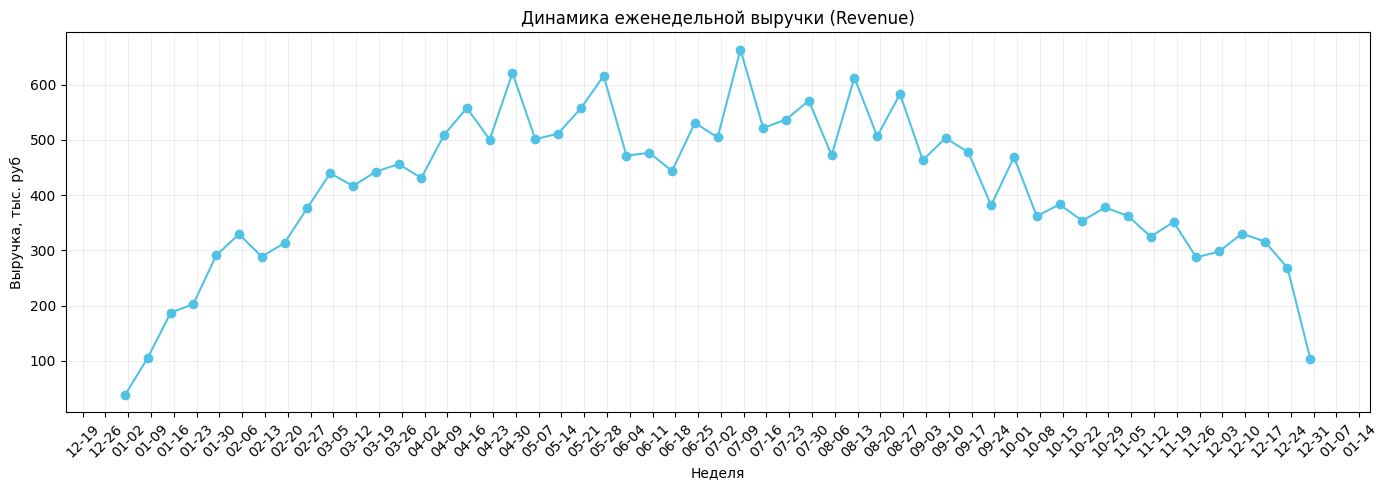

In [12]:
# агрегируем по неделям с помощью Grouper и сразу считаем 5% от выручки
# ⚠️ сразу посчитаем количество заказов - пригодится при расчете CR в заказ❗
orders_w = (
    ds['orders']
    .groupby(pd.Grouper(key='order_date', freq='W-MON', closed='left', label='left'))
    .agg(
        revenue = ('total_price', 'sum'),
        orders_cnt = ('order_id', 'nunique')
    )
    .reset_index()
    .rename(columns={'order_date': 'order_week'})
)
# print(orders_w)
orders_w['revenue'] = orders_w['revenue']*0.05 
orders_w['revenue_k'] = orders_w['revenue'] / 1000

# строим график
plt.figure(figsize=(14, 5))
plt.plot(orders_w['order_week'],  orders_w['revenue_k'], 
         marker='o', color=pal[1])

plt.title('Динамика еженедельной выручки (Revenue)')
plt.xlabel('Неделя')
plt.ylabel('Выручка, тыс. руб')
plt.grid(alpha=0.3, linewidth=0.5)

ax = plt.gca()  # получаем текущие оси
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))  # метки с интервалом 1 неделя
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))  # формат даты
plt.xticks(rotation=45)
plt.tight_layout()       # чтобы ничего не обрезалось

plt.show()


**Недельная выручка**

- можно выделить три периода
    - **рост ~40k → ~550k**: начало января - середина апреля 
    - **стабилизация ~550k ± 70k**: середина апреля - конец августа 
    - **падение ~550k → 100k**: конец августа - конец декабря 

**⚠️Таким образом с конца лета и до конца года выручка упала в 5.5 раз**🤔

#### ARPU и ARPPU


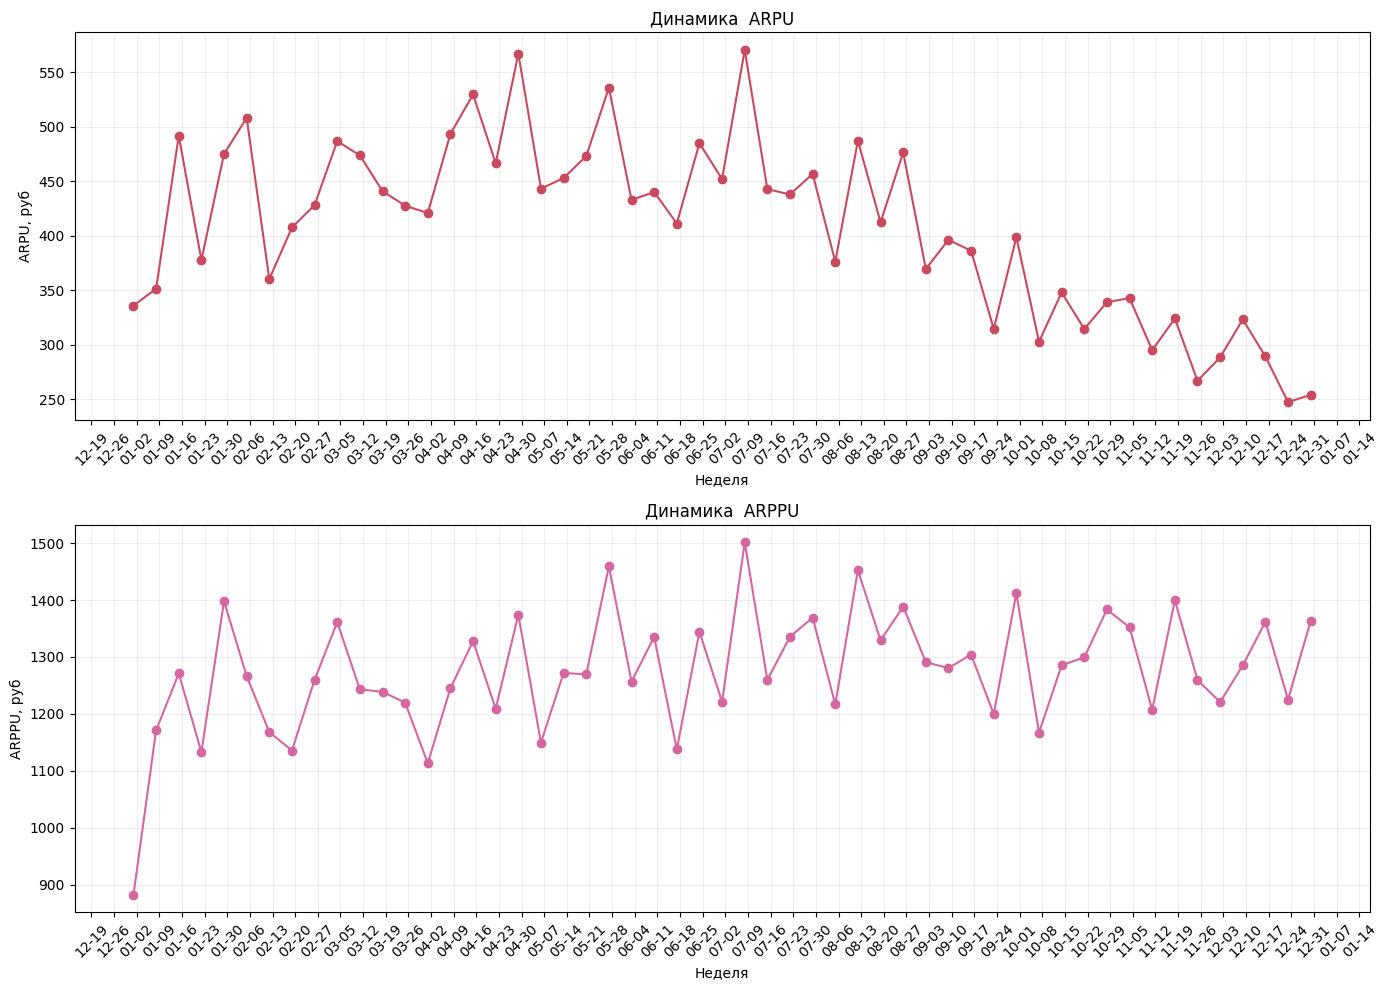

In [ ]:
# считаем недельную выручку и кол-во покупателей
#⚠️ для правильного расчета freq='W-MON', closed='left', label='left'
rp_w = (
    ds['orders']
    .groupby(pd.Grouper(
        key='order_date',  
        freq='W-MON',      # Неделя начинается в понедельник
        closed='left',     # Интервал [начало, конец)
        label='left'       # Метка = дата начала интервала
    ))
    .agg(
        revenue = ('total_price', 'sum'),   
        payers_cnt = ('user_id', 'nunique')   
    )
    .reset_index()
    .rename(columns={'total_price': 'revenue', 'order_date': 'order_week'})
)

# не забываем что бизнес зарабатывает с комиссии (5%)
rp_w['revenue'] = rp_w['revenue']*0.05 

# считаем недельное кол-во всех пользователей       
u_w = (
    ds['sessions']
    .groupby(pd.Grouper(key='session_start', freq='W-MON', 
                        closed='left', label='left'))
    ['user_id']
    .nunique()
    .reset_index()
    .rename(columns={'user_id': 'users_cnt', 'session_start': 'ses_week'})
)

# считаем метрики
avg_rev = rp_w.merge(u_w, left_on='order_week', right_on= 'ses_week' )
avg_rev['arpu'] = avg_rev['revenue'] / avg_rev['users_cnt']
avg_rev['arppu'] = avg_rev['revenue'] / avg_rev['payers_cnt']

# ------------------------------------------------------------------------------
# строим графики
fig, ax = plt.subplots(2, 1, figsize=(14, 10))
for i, met in enumerate(['arpu', 'arppu']):
    ax[i].plot(avg_rev['order_week'], avg_rev[met], marker='o', color=pal[3*i])
    ax[i].set_title(F'Динамика  {met.upper()}')
    ax[i].set_xlabel('Неделя')
    ax[i].set_ylabel(f'{met.upper()}, руб')
    ax[i].grid(alpha=0.3, linewidth=0.5)
    ax[i].xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    for label in ax[i].get_xticklabels():
        label.set_rotation(45)
plt.tight_layout()
plt.show()

# display(Markdown(avg_rev.to_markdown()))


**ARPU:** 
- Выручка на активного имеет **высокую волатильность** - локальные колебания до ~150 руб
- Несмотря на это, прослеживается трендовая динамика - рост до августа и последующее падение.

**ARPPU:**
- В отличие от ARPU **значительно более стабильна**
- В основном колеблется вокруг среднего значения ~1300 ± 100 руб  без явного тренда.
- На самом деле, есть небольшой ростовой тренд до августа, но с учетом масштаба средних значений обоих метрик  
(1200 vs 400) им можно пренебречь. Тем более что нас в первую очередь интересует падение выручки в 5.5 раз в последние   
месяцы года, а не ее рост в первом полугодии. 

Падение общей выручки и ARPU **не связано с тем, что платящие пользователи стали тратить меньше**. Они по-прежнему  
тратят столько же. Падение ARPU при стабильном ARPPU указывает на то, что **снизилась конверсия в платящих**. Всё  
меньше активных пользователей на сайте становятся покупателями.

Теперь рассмотрим динамику активности пользователей. Ведь конверсия могла снизиться в том числе из-за увеличения числа  
активных пользователей.

#### DAU, WAU, MAU и stickiness

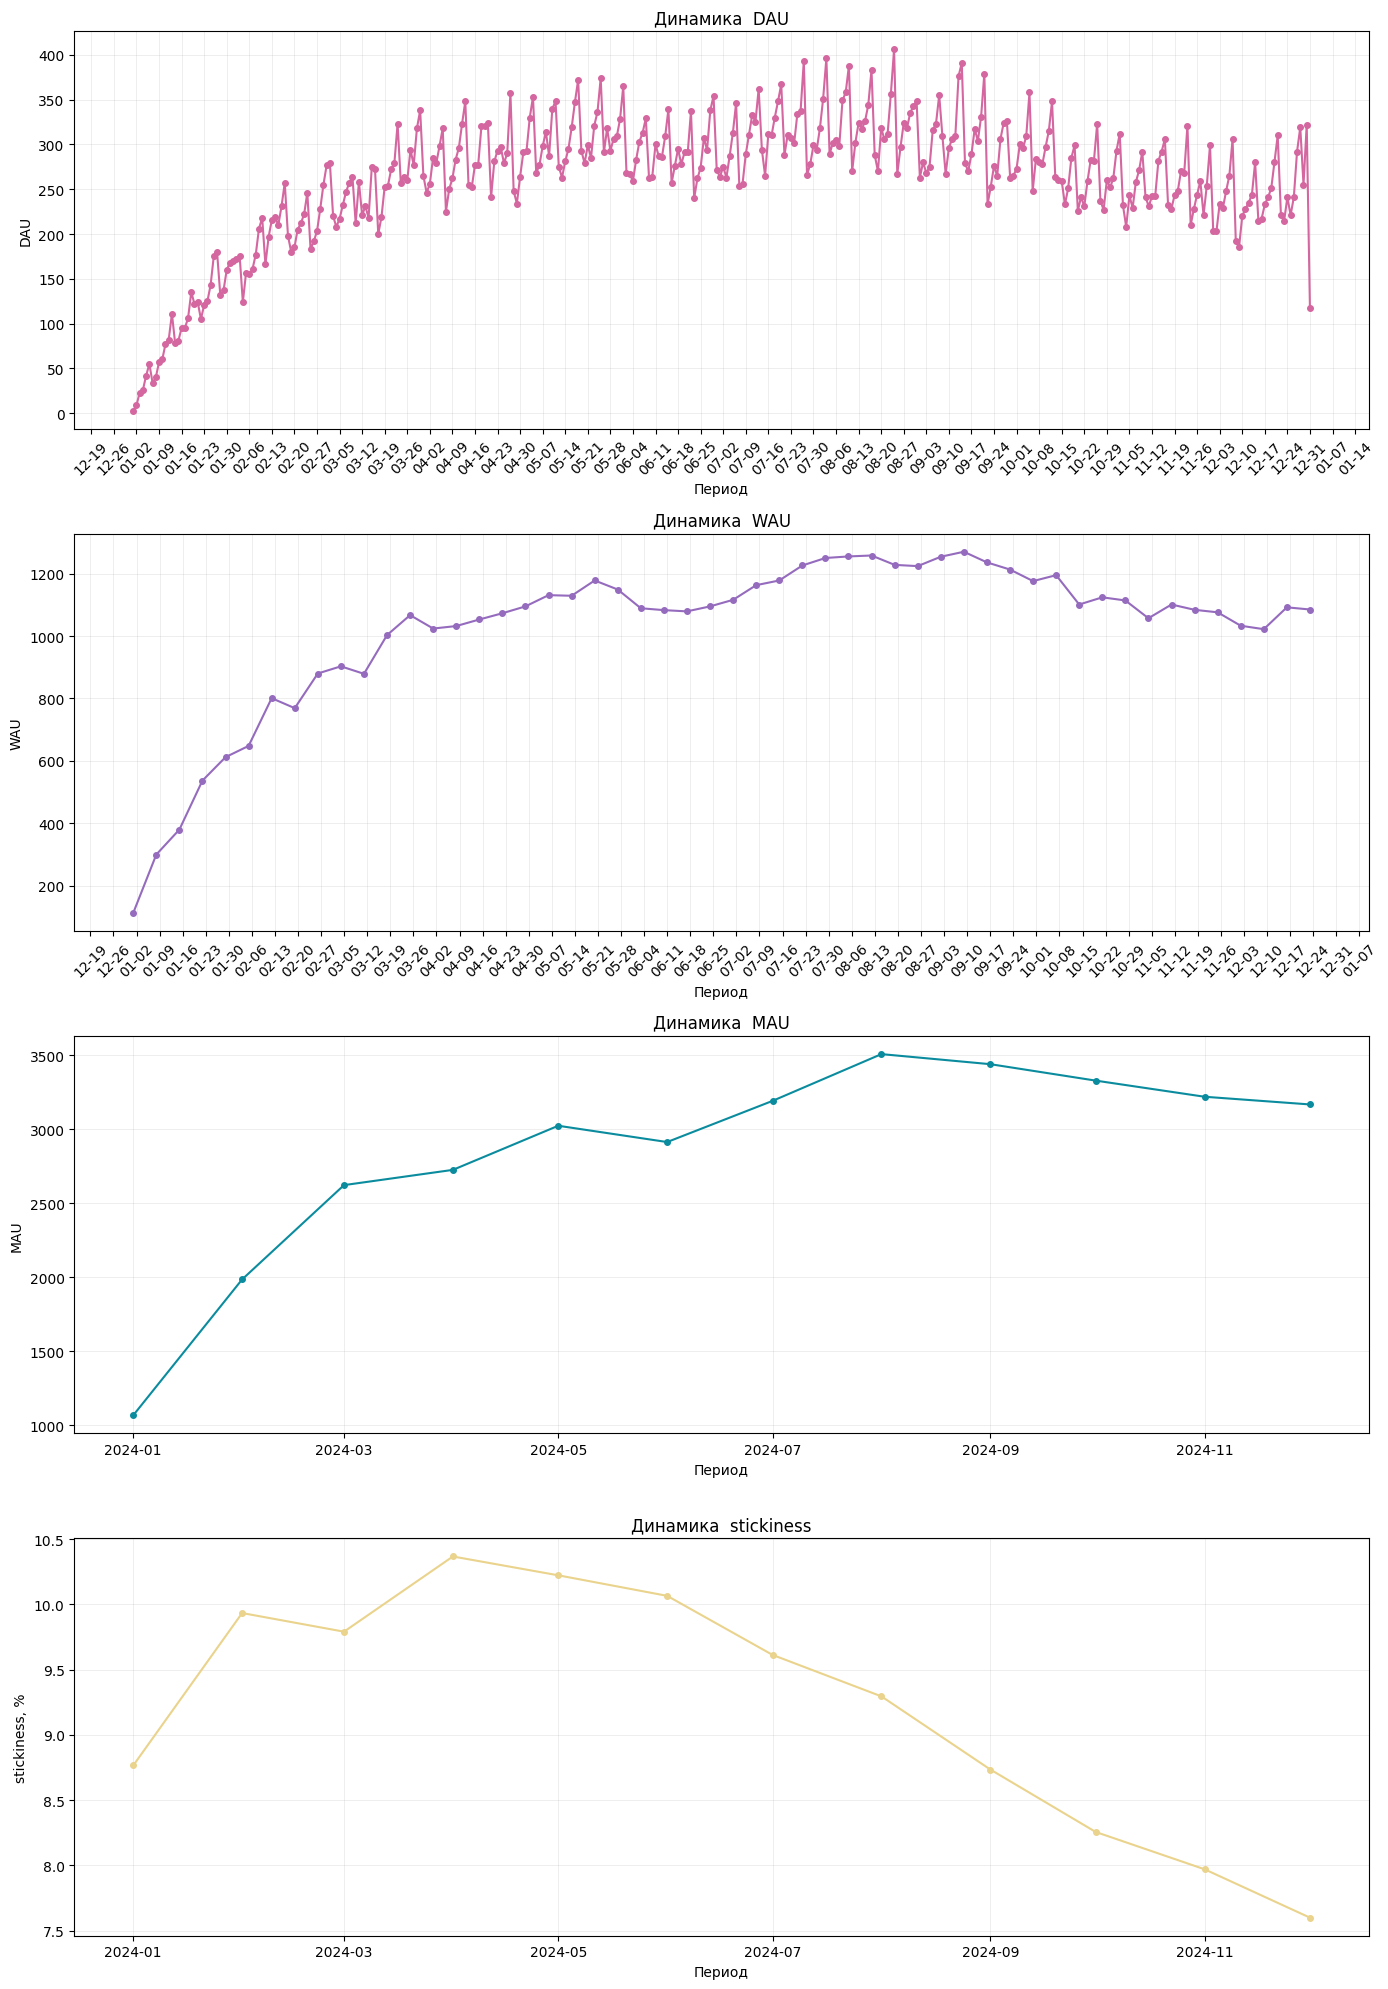

In [14]:
# словарь с параметрами для (x)AU метрик
grouper_params = {
    'DAU': {'freq': 'D'},
    'WAU': {'freq': 'W-MON', 'closed': 'left', 'label': 'left'},
    'MAU': {'freq': 'MS'} # MS - Month Start группировать на начало месяца
}

# пустой словарь для хранения результатов
au_metrics = {}

# расчет (x)AU метрик 
for met, params in grouper_params.items():
    au_metrics[met] = (
        ds['sessions']
        .groupby(pd.Grouper(key='session_start', **params)) 
        ['user_id']
        .nunique()
        .reset_index()
        .rename(columns={'user_id': met, 'session_start': 'date'})
    )
    
# ------------------------------------------------------------------------------
# расчет stickiness  = monthly_avg_DAU * 100 / MAU
stickiness  = (
    au_metrics['DAU']
    .groupby(au_metrics['DAU']['date'].dt.to_period('M').dt.to_timestamp())
    ['DAU']
    .mean()
    .mul(100)
    .div(au_metrics['MAU'].set_index('date')['MAU'])
    .reset_index()
    .rename(columns={0: 'stickiness'})
)

au_metrics['stickiness'] = stickiness

# ------------------------------------------------------------------------------
# строим графики
fig, ax = plt.subplots(4, 1, figsize=(14, 20))

for i, (name, met_dirty) in enumerate(au_metrics.items()):
    # ⚠️ обрубаем хвост WAU  - последняя неделя не полная 
    met = met_dirty[:-1] if name == 'WAU' else met_dirty
    # строим график
    ax[i].plot(met['date'], met[name], marker='o', color=pal[i+3], markersize=4)
    ax[i].set_title(F'Динамика  {name}')
    ax[i].set_xlabel('Период')
    ax[i].set_ylabel(f'{name}, %' if name[:3] =='sti' else f'{name}')
    ax[i].grid(alpha=0.3, linewidth=0.5)
    
    # настройки оси x для DAU и WAU
    if name in ['DAU', 'WAU']:        
        ax[i].xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
        ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        for label in ax[i].get_xticklabels():
            label.set_rotation(45)


plt.tight_layout()
plt.show()


**DAU**
- метрика ожидаемо "шумная", но можно выделить 3 периода
    - рост от 0 до 300 пользователей в первом квартале
    - стабилизация в диапазоне 320 ± 80 с начала апреля и до середины сентября
    - снижение в диапазон 250 ± 70 пользователей в день с середины сентября и до конца года
- 31 декабря ожидаемо провал активности (Новый Год - люди заняты собой)


**WAU**
- меньше шума, но движение схожее: 
    - рост 150 → 1000  в первом квартале
    - медленный рост 1000 → 1250  с начала апреля и до середины сентября
    - медленное снижение 1250 → 1050 с середины сентября и до конца года

**MAU**
- динамика еще более сглаженная, из-за чего всего 2 фазы, но в остальном характер движения схожий
    - рост с затуханием 1000 → 3500 первые 8 месяцев
    - медленное снижение  3500  → 3150
 
**stickiness**
- рост 8.8  → 10.4 первые 4 месяца  
- стабильное снижение  10.4 → 7.6 с мая и до конца года  


Основной рост аудитории (DAU, WAU, MAU) пришелся на первый квартал, после чего наступило плато и медленное падение  
ближе к концу года. Продукт перестал активно привлекать новых пользователей. Динамика метрик активности не выглядит  
драматично.

Куда интересней падение stickiness на 27% c апреля по декабрь. Оно говорит о том, что упала вовлеченность пользователей.   
Возможно это одна из причин снижения выручки.


#### Средний чек (AOV) и средняя выручка с заказа (APRO)


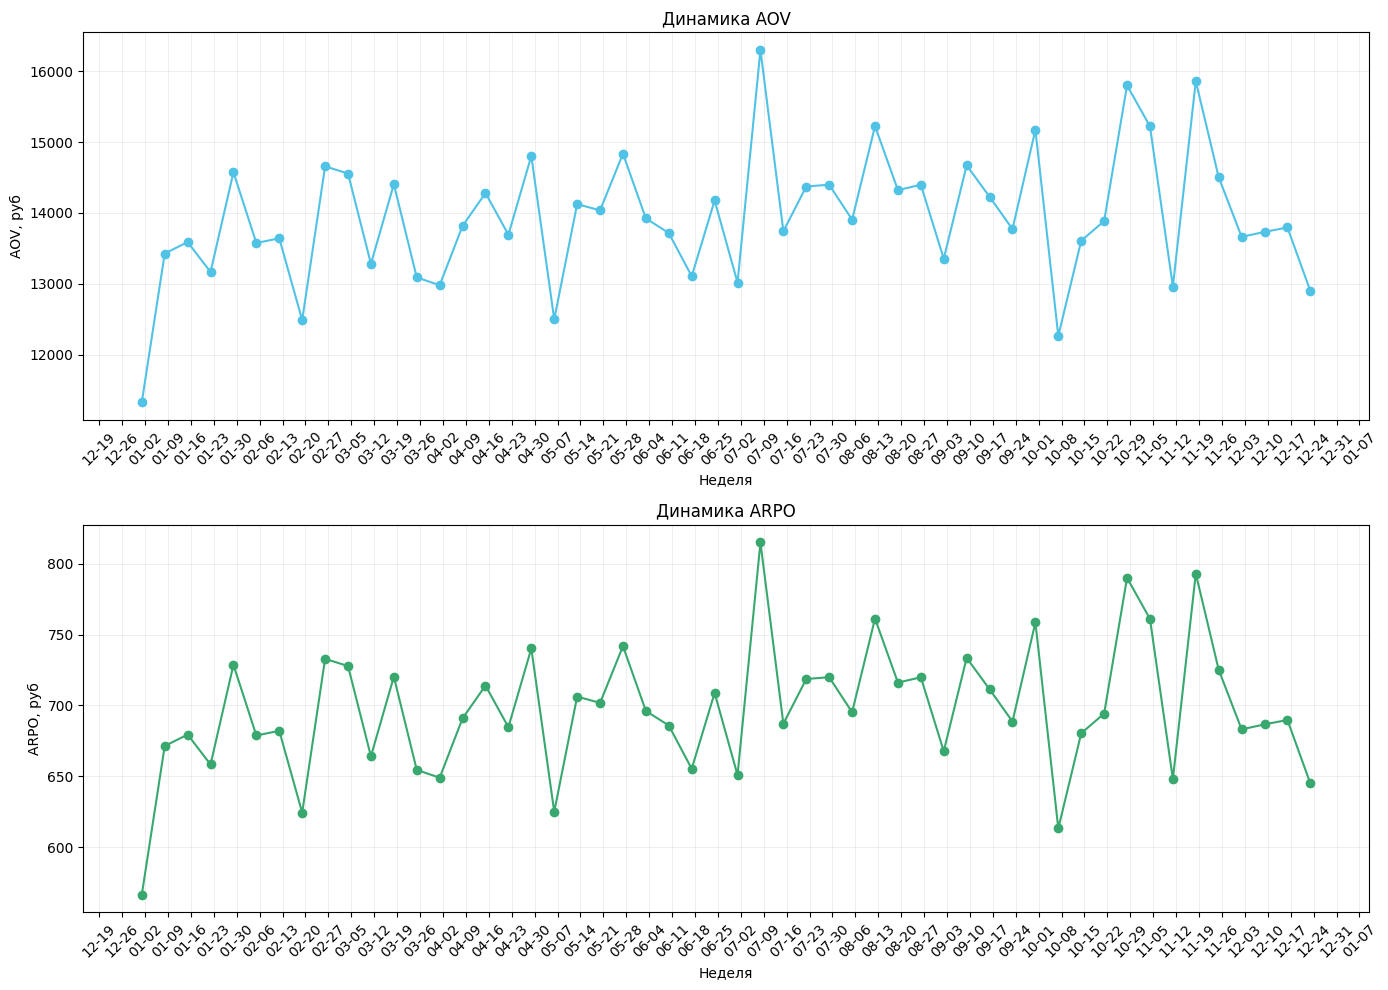

In [15]:
# для удобства
orders = ds['orders']

# считаем aov (группируем по чеку, затем по неделям)
aov_arpo = (
    ds['orders']
    .groupby(['order_id'])
    .agg(
        order_date = ('order_date', 'first'),
        check = ('total_price', 'sum')
    )
    .groupby(pd.Grouper(key='order_date', freq='W-MON', 
                        closed='left', label='left'))
    ['check'].mean()   
    .reset_index()
    .rename(columns={'check': 'AOV', 'order_date': 'order_week'})
)

# добавляем среднюю выручку с заказа (комиссия бизнеса 5%)
aov_arpo['ARPO'] = aov_arpo['AOV'] * 0.05

# ------------------------------------------------------------------------------
# строим графики 
fig, ax = plt.subplots(2, 1, figsize=(14, 10))

for i, met in enumerate(['AOV', 'ARPO']):
    # ⚠️  Обрубаем хвост. Последняя точка по неполным данным
    df = aov_arpo[:-1]
    
    ax[i].plot(df['order_week'], df[met], marker='o', color=pal[i+1])
    ax[i].set_title(f'Динамика {met}')
    ax[i].set_xlabel('Неделя')
    ax[i].set_ylabel(f'{met}, руб')
    ax[i].grid(alpha=0.3, linewidth=0.5)
    
    # Настройки оси X
    ax[i].xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    for label in ax[i].get_xticklabels():
        label.set_rotation(45)

plt.tight_layout()
plt.show()

**AOV**
- **метрика стабильна** в течение всего года и колеблется вокруг среднего значения ~14k
- наблюдается **высокая волатильность** недельных значений (до ± 2k руб), но движение безтредовое

**ARPO (средняя выручка с заказа)**
- Динамика аналогичная AOV но в меньшем масштабе. Годовой диапазон значений ~700 ± 110 руб


**Падение общей выручки не связано с динамикой среднего чека.**

#### Retention
- анализ будем вести по месячным когортам - люди, в основном, делают покупки на маркетплейсах не каждую неделю

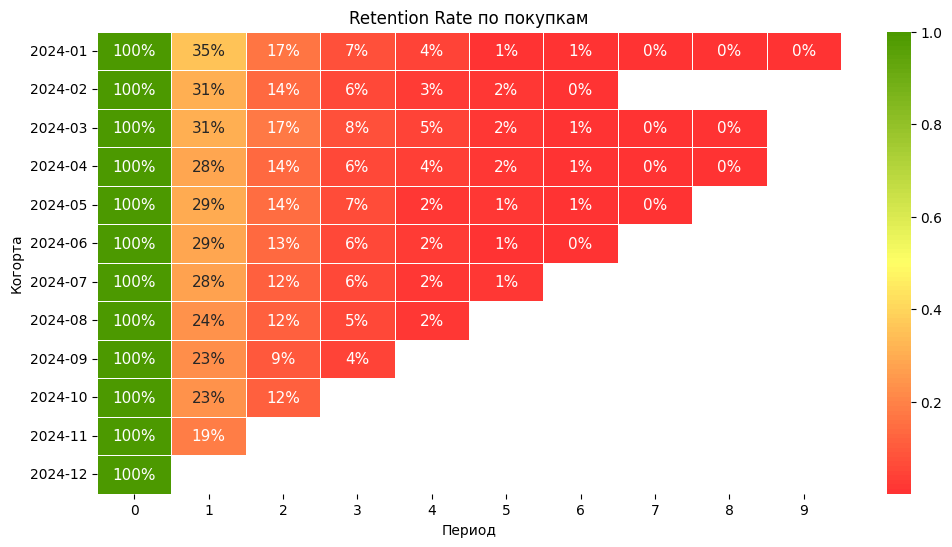

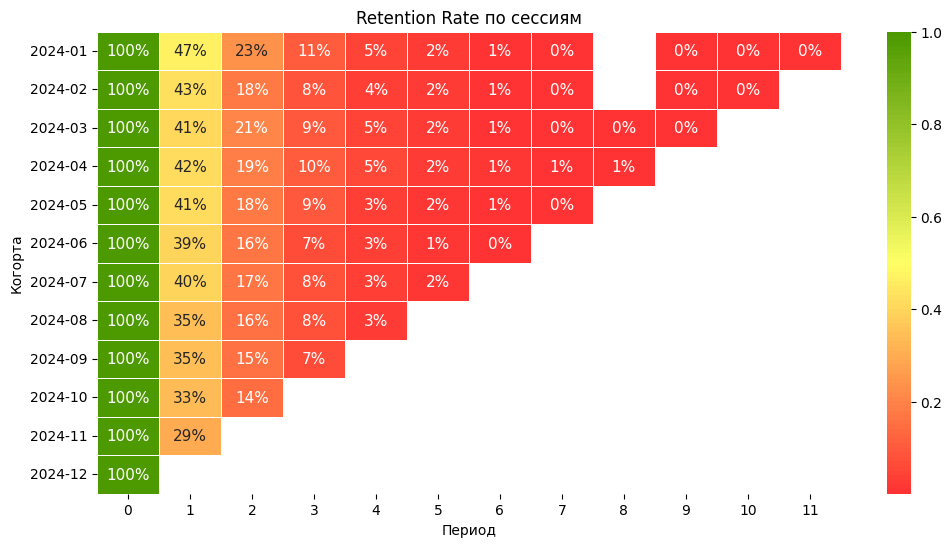

In [16]:
def calc_retention(df, date_col):
    # создаем копию
    data = df.copy()
    
    # текущий и первый месяцы активности и их дельта
    data['act_mon'] = pd.to_datetime(data[date_col]).dt.to_period('M')
    data['first_act_mon'] = data.groupby('user_id')['act_mon'].transform('min')
    data['n_period'] = (data['act_mon'] - 
                        data['first_act_mon']).apply(lambda x: x.n)
    
    # считаем сводную таблицу
    df_pivot_au = data.pivot_table(
        index='first_act_mon',
        columns='n_period',
        values='user_id',
        aggfunc='nunique'
    )

    # считаем retention
    retention = df_pivot_au.div(df_pivot_au[0], axis=0)
    return data, retention

def plot_heatmap(df, title, params):
    # строим графики
    plt.figure(figsize=(12, 6))
    sns.heatmap(df, **params)
    plt.title(title)
    plt.xlabel('Период')
    plt.ylabel('Когорта')
    plt.show()


# ⚠️ перезаписываем словарь ds - таблицы те же но добавлены новые поля  
ds['orders'], orders_retention = calc_retention(ds['orders'], 'order_date')
ds['sessions'], sessions_retention = calc_retention(ds['sessions'], 'session_start')

# строим графики
plot_heatmap(orders_retention, 'Retention Rate по покупкам', heatmap_pct_params)
plot_heatmap(sessions_retention, 'Retention Rate по сессиям', heatmap_pct_params)

# display(Markdown(orders_retention.to_markdown()))
# display(Markdown(sessions_retention.to_markdown()))


**Удержание по покупкам:**
- На второй месяц возвращаются за покупкой **20-35%** пользователей, но этот показатель **упал с 35% до 19%** для когорт   
с января по ноябрь.
- После 3-4 месяцев в когортах остается **менее 10%** платящих.

**Удержание по активности (сессиям):**
- Показатели **существенно выше**, но тренд **аналогичный**: удержание на второй месяц **упало с 47% до 29%**.

Продукт **плохо удерживает пользователей**, причем качество удержания **ухудшилось** для когорт, привлеченных во  
второй половине года. То что удержание по активности выше, чем по покупкам, говорит о том, что пользователи  
**чаще заходят на сайт, чем покупают**. Падение обеих метрик для новых когорт, наряду со снижением `stickiness`,  
является основной причиной падения выручки. Бизнес стал привлекать менее вовлеченную и менее платежеспособную аудиторию.

#### CTR
- **CTR = Clicks /  Views * 100%**
- **Views:** product_view
- **Clicks:** product_click

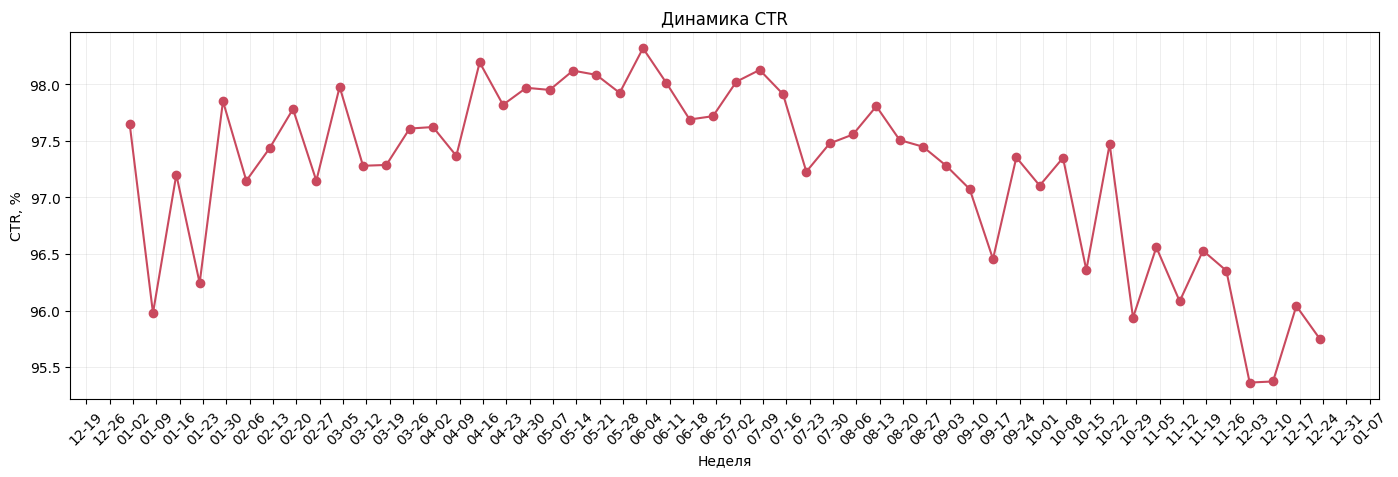

In [47]:
# для удобства
events = ds['events']

# считаем ctr
ctr = (
    events[
        events['event_type']
        .isin(['product_view', 'product_click']
    )]
    .groupby([
        pd.Grouper(key='event_date', freq='W-MON', closed='left', label='left'),
        'event_type'
    ])
    .size()                       # размер групп
    .unstack(level='event_type')  # разворачиваем в колонки
    .assign(CTR=lambda x: x['product_click'] * 100 / x['product_view']) # ctr
    .reset_index()
    .rename(columns = {'event_date': 'event_week'})
)

# ------------------------------------------------------------------------------
# строим графики
# ⚠️ ctr['CTR'][:-1] - обрубаем хвост.  последняя точка по неполным данным
plt.figure(figsize=(14, 5))
plt.plot(ctr['event_week'][:-1], ctr['CTR'][:-1], marker='o', color=pal[0])
plt.title('Динамика CTR')
plt.xlabel('Неделя')
plt.ylabel(f'CTR, %')
plt.grid(alpha=0.3, linewidth=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.show()
# display(Markdown(ctr.to_markdown()))


**CTR**
- небольшой рост 96% → 98% в первые 5 месяцев
- небольшое снижение 98% → 95.5%  до конца года

**Метрика в порядке. Размах колебаний около 3% в течении года - это очень хороший результат.**

#### CR в заказ
- **CR = Количество заказов / Количество сессий * 100%**
- **Количество заказов**: nunique(order_id) из таблицы orders.
- **Количество сессий**: nunique(session_id) из таблицы sessions.

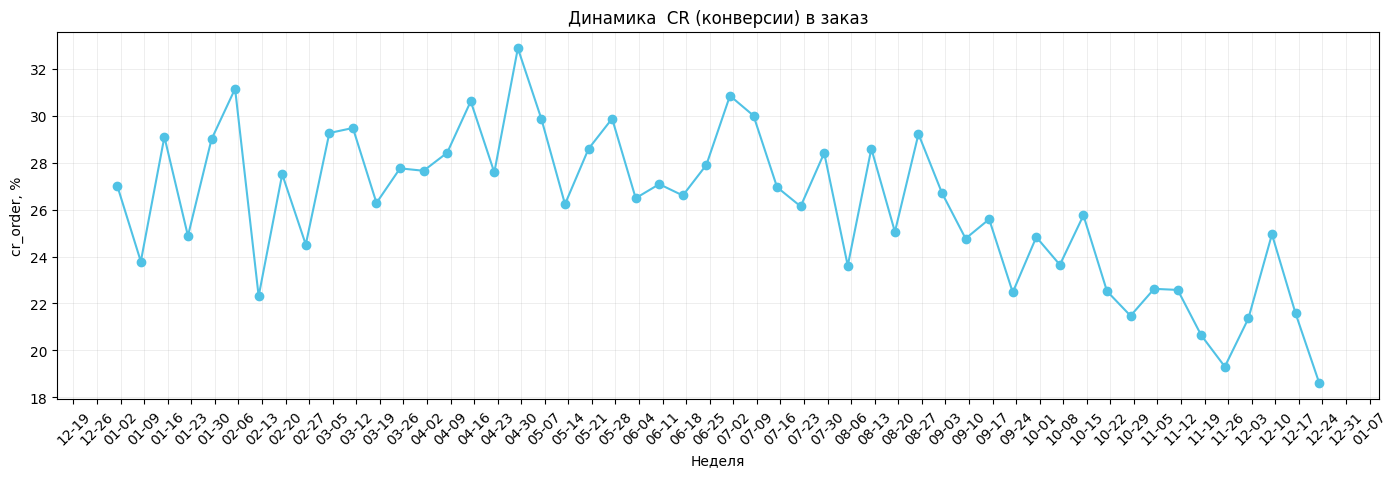

In [18]:
# для удобства
orders, sessions  = ds['orders'], ds['sessions']

# ⚠️ ранее мы рассчитали  количество заказов в orders_w - используем❗
cr = (
    sessions
    .assign(week = lambda x : x['session_start']
                                .dt.to_period('W').dt.to_timestamp())
    [['session_id', 'week']]
    .merge(orders_w[['orders_cnt', 'order_week']], how='left', 
           left_on='week', right_on='order_week')
    .fillna({'orders_cnt': 0})
    .groupby('week')
    .agg(
        orders_cnt = ('orders_cnt', 'first'),
        sessions_cnt = ('session_id', 'nunique')
    )
    .assign(cr_order = lambda x: x['orders_cnt'] *100 / x['sessions_cnt'] )
    .reset_index()
)

# ------------------------------------------------------------------------------
# строим графики
# ⚠️ cr['cr_order'][:-1] - обрубаем хвост.  последняя точка по неполным данным
plt.figure(figsize=(14, 5))
plt.plot(cr['week'][:-1], cr['cr_order'][:-1], marker='o', color=pal[1])
plt.title('Динамика  CR (конверсии) в заказ')
plt.xlabel('Неделя')
plt.ylabel(f'cr_order, %')
plt.grid(alpha=0.3, linewidth=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.show()
# display(Markdown(cr.to_markdown()))

**CR в заказ**
- Рост и стабилизация с ~24% до ~30-32% в первом полугодии. 
- Снижение во втором полугодии, начиная с августа с ~30% до ~20%.
- Высокая волатильность

Снижение CR в заказ во втором полугодии, наряду со снижением stickiness и retention, является еще одним подтверждением  
основной проблемы: **качество аудитории и ее вовлеченность упали**, что стало приводить к меньшему числу заказов.

#### Промежуточный вывод по ключевым метрикам 
**Revenue**  
С конца лета и до конца года недельная выручка упала в 5.5 раз (~550k → 100k)**

**Stickiness**  
Вовлеченность пользователей упала с 10.4%  до 7.6% (то есть на 27%) c апреля по декабрь. 

**Retention Rate**  
- удержание на второй месяц упало вдвое с января (35%) по ноябрь (19%) 
- на 4 месяц во всех когортах остается менее 10% платящих пользователей.

**CR в заказ**  
Снижение CR в заказ с августа с ~30% до ~20% 

### 3. Оценка метрик монетизации и юнит-экономики

**ARPU и AOV**  

Ранее мы уже проанализировали динамику выручки на пользователя (ARPU) и средний чек (AOV) .
- **AOV**. Средний чек оказался стабилен в течение всего года. Значит, он не является причиной падения общей выручки.
- **ARPU**. У выручки на пользователя устойчивый тренд на снижение во втором полугодии, что совпадает с падением общей  
выручки. В то же время **ARPPU** (на платящего польз-ля) очень стабилен в течение года. 

Это указывает на то, что проблема не в сумме покупок, а в качестве привлекаемой аудитории (вовлеченности) ее удержании  
и конверсии в покупателей.

Теперь перейдем к анализу эффективности затрат на привлечение (CAC, LTV, ROI).


#### CAC
- CAC = (Бюджет за месяц) / (Количество привлеченных в этом месяце)

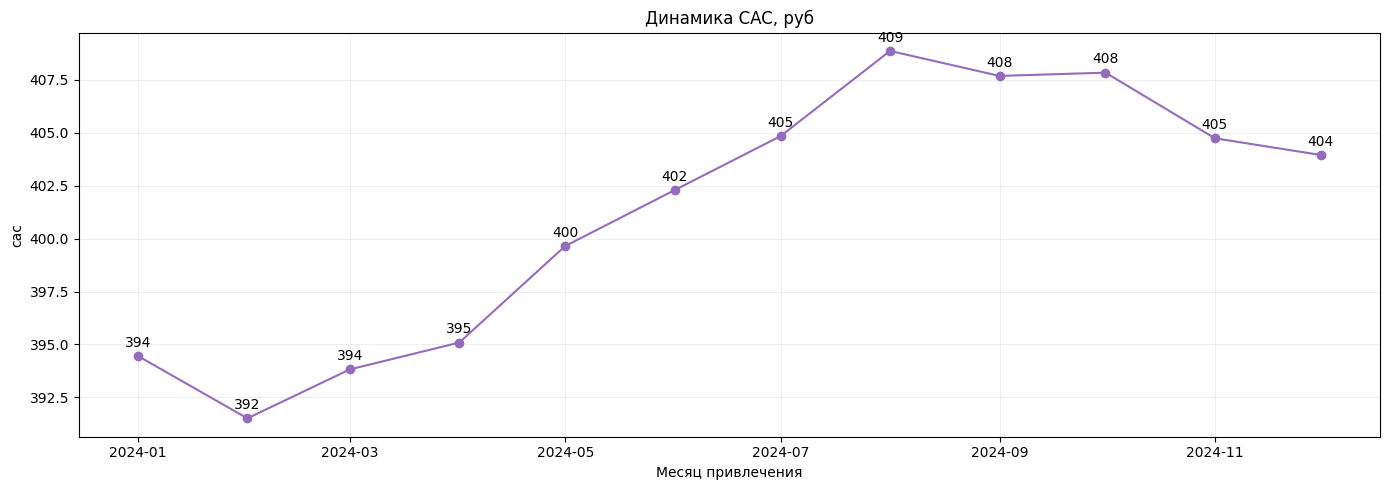

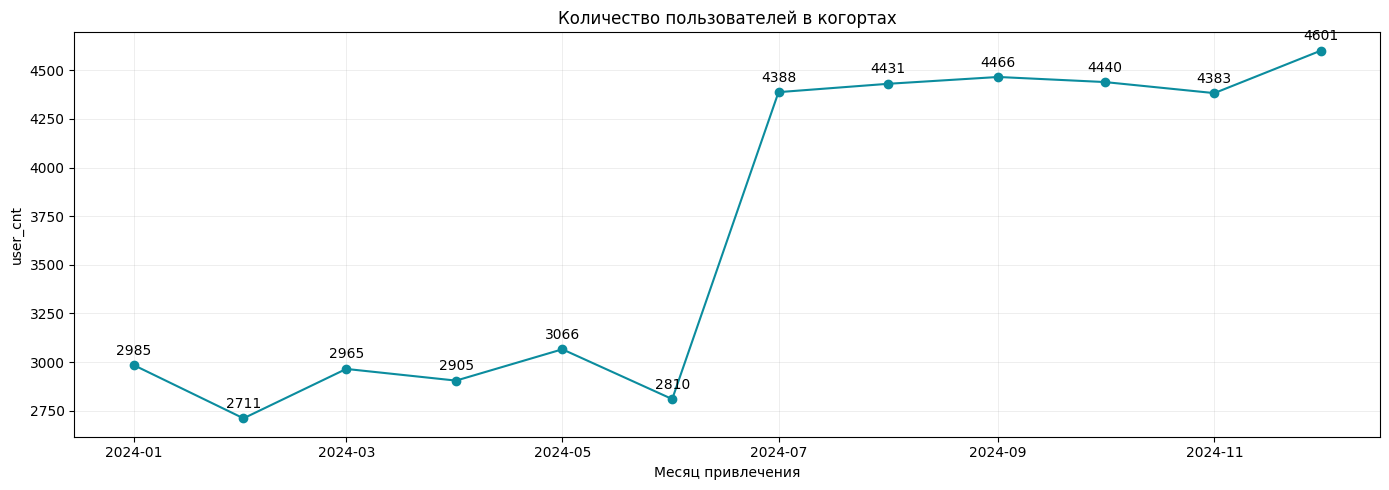

In [19]:
# для удобства
users, campaigns = ds['users'], ds['campaign_costs']
users.columns

# считаем
CAC = (
    users
    .groupby('cohort_month')['user_id']
    .nunique()
    .reset_index(name = 'user_cnt')
    .merge(
        campaigns.groupby('spend_month')['budget'].sum().reset_index(),  
        left_on='cohort_month', right_on='spend_month'
    )
)

CAC['cac'] = CAC['budget'] / CAC['user_cnt']


# ------------------------------------------------------------------------------
# строим графики
met_dict = {'cac': 'Динамика CAC, руб', 
            'user_cnt': 'Количество пользователей в когортах'}

for i, (met, desc) in enumerate(met_dict.items()):
    plt.figure(figsize=(14, 5))
    plt.plot(CAC['cohort_month'], CAC[met], marker='o', color=pal[i+4])
    for x_coord, y_coord in zip(CAC['cohort_month'], CAC[met]):
        
        # 0.3 * (i+1)**7 - не элегантный способ поднять подписи для 2 графика 
        plt.text(x_coord, y_coord + 0.3*(i+1)**7 , f'{round(y_coord)}',
                    ha='center', va='bottom')

    plt.title(desc)
    plt.xlabel('Месяц привлечения')
    plt.ylabel(met)
    plt.grid(alpha=0.3, linewidth=0.5)
    plt.tight_layout()
    plt.show()



САС  очень стабилен. Диапазон изменений за год - 17 руб [392, 409], что составляет примерно 4.3%

А вот объем привлечения (размер когорт) изменился драматично во второй половине года, увеличившись примерно в 1.5 раза
- если с январа по июль количество привлекаемых пользователей в месяц в среднем составляло примерно 2900 
- то начиная с июля и до конца года это значение поднялось примерно до 4450

Таким образом, подтверждается предположение о привлечении нецелевого трафика. Как мы видели ранее (по просевшим метрикам  
вовлеченности, удержания и конверсии), этот новый, более массовый трафик оказался нецелевым. Поэтому затраты не окупились,  
что и привело в конечном счете к снижению общей выручки.

#### LTV

Ранее в таблице orders мы уже посчитали 
- **first_act_month** — когорта пользователя
- **n_period** — период с момента первого заказа

Используем их

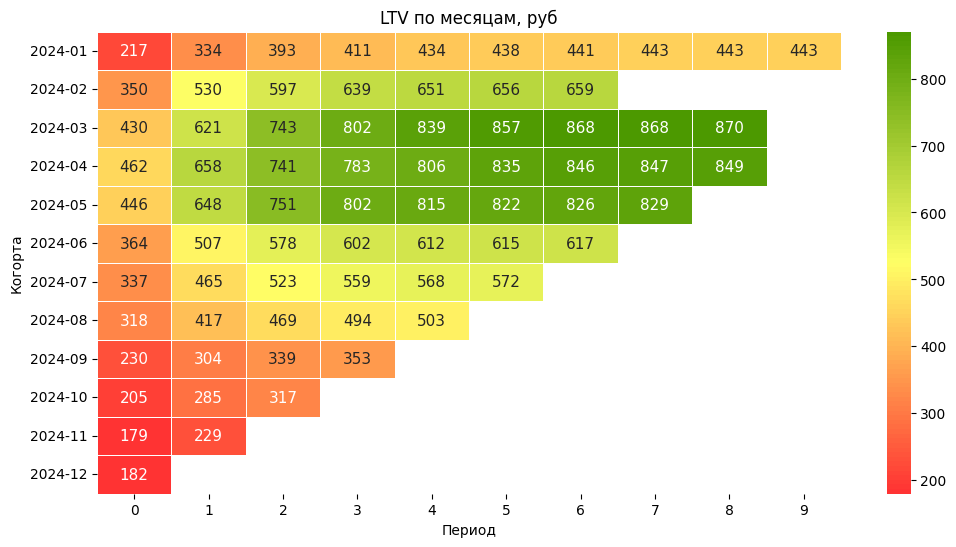

In [20]:
# можно посмотреть набор полей
# print(orders.columns)
# print(users.columns)

# считаем накопленную выручку 
pivot_gmv = orders.pivot_table(
    index='first_act_mon',
    columns='n_period',
    values='total_price',
    aggfunc='sum'
)
cum_gmv = pivot_gmv.cumsum(axis=1)

# считаем пользователей когорты
cohort_size = (
    users
    .groupby('cohort_month')['user_id']
    .nunique()
)

# приводим индексы к единому формату для того чтобы сработало деление (.div()) 
cohort_size.index = cohort_size.index.to_period('M')

# считаем LTV (не забываем про 5%)
LTV = cum_gmv.div(cohort_size, axis=0).mul(0.05)

# ------------------------------------------------------------------------------
# строим тепловую карту
plot_heatmap(LTV, 'LTV по месяцам, руб', heatmap_val_params)

# display(Markdown(LTV.to_markdown()))

-   январская когорта "слабая" - рост LTV в ней очень плавный и метрика так и не превышает 450 руб даже к концу года.
-   наиболее сильные когорты: март, апрель и май. Они уже на 3-й месяц выходят в "зеленую область" на уровень ~750 руб -  
    уровень который остается недостижим другими когортами. А на 8-9 месяц достигают ~860 руб.
-   начиная с лета и до конца года каждая последующая когорта приносит все меньше прибыли. Это можно увидеть если  
    посмотреть на LTV, например, на 3 месяц жизни (период 2). В майской когорте он составляет 750 руб, а в июньской 578 руб,   
    при этом с июня наблюдается снижение до 317 руб в октябре.

#### ROI

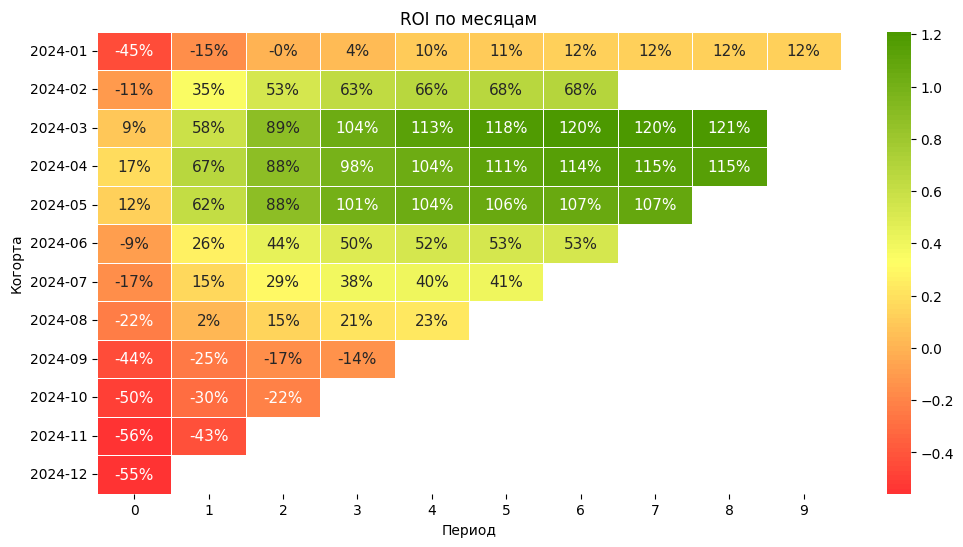

In [21]:
# приводим к единому формату индекса
cac_series = CAC.set_index('cohort_month')['cac']
cac_series.index = cac_series.index.to_period('M')

# считаем ROI
profit = LTV.sub(cac_series, axis=0)
ROI = profit.div(cac_series, axis=0).mul(100)

# ------------------------------------------------------------------------------
# строим тепловую карту
plot_heatmap(ROI/100, 'ROI по месяцам', heatmap_pct_params)


- Январская когорта, а также когорты с июня по август, начинают с отрицательного ROI и окупаются только на 2-3 месяц.
- Сильные когорты (март, апрель, май) сразу же выходят в плюс и показывают самый высокий ROI - свыше 100% уже на 4   
месяц (период 3)
- Начиная с июня, ROI значительно падает. А с сентября даже не успевают окупиться за 3-4 месяца.

Анализ ROI полностью подтверждает все предыдущие выводы. Эффективность маркетинга резко упала в середине года.  
Новые пользователи стали не только менее вовлеченными и прибыльными (LTV), но и перестали окупать затраты на свое  
привлечение (ROI).

#### Payback Period

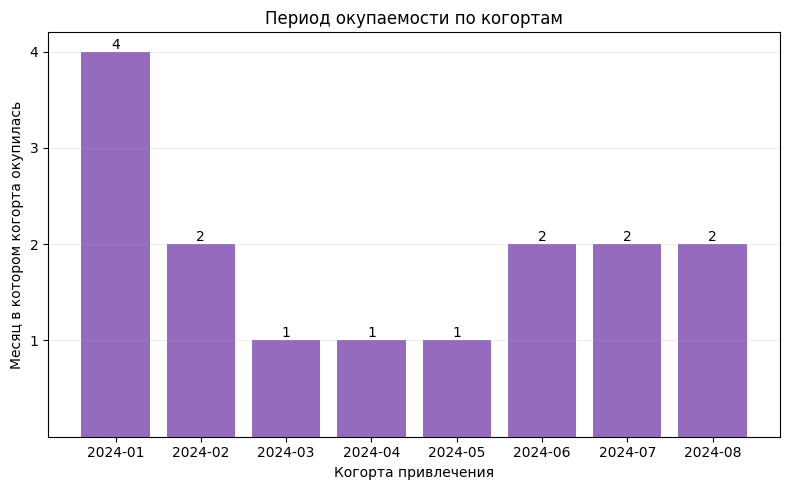

In [22]:
# находим номер первого периода, где ROI >= 0
pb_period = (ROI >= 0).idxmax(axis=1)
# оставляем только те когорты, которые вообще окупились
# добавляем 1, так как нумерация периодов с 0
pb_period = pb_period[(ROI >= 0).any(axis=1)] + 1

plt.figure(figsize=(8, 5))

# преобразуем PeriodIndex в строки для красивых меток
pb_period.index = pb_period.index.strftime('%Y-%m')

# строим график
bars = plt.bar(pb_period.index, pb_period.values, color=pal[4])
plt.bar_label(bars) # ⚠️ не работает в Практикуме🤔  версия matplotlib 3.3.4 а надо 3.4.x 
plt.title('Период окупаемости по когортам')
plt.xlabel('Когорта привлечения')
plt.ylabel('Месяц в котором когорта окупилась')
plt.yticks(np.arange(1, int(pb_period.max()) + 1, 1))
plt.grid(axis='y', alpha=0.3, linewidth=0.5)
plt.tight_layout()
plt.show()

# display(Markdown(pb_period.to_markdown()))


- быстрая окупаемость у весенних когорт, привлеченных с марта по май - окупались сразу же, в первый месяц
- увеличение срока окупаемости у летних когорт (июнь-август) - срок окупаемости вырос до 2 месяцев
- проблемные когорты (сентябрьская и последующие) вообще не успели окупиться за время наблюдении


График периода окупаемости наглядно подтверждает резкое падение эффективности маркетинговых вложений с начала лета.  
К осени когорты и вовсе перестали окупаться за обозримый период.

#### LTV, CAC и ROI на 3 месяц жизни когорт (n_period=2)

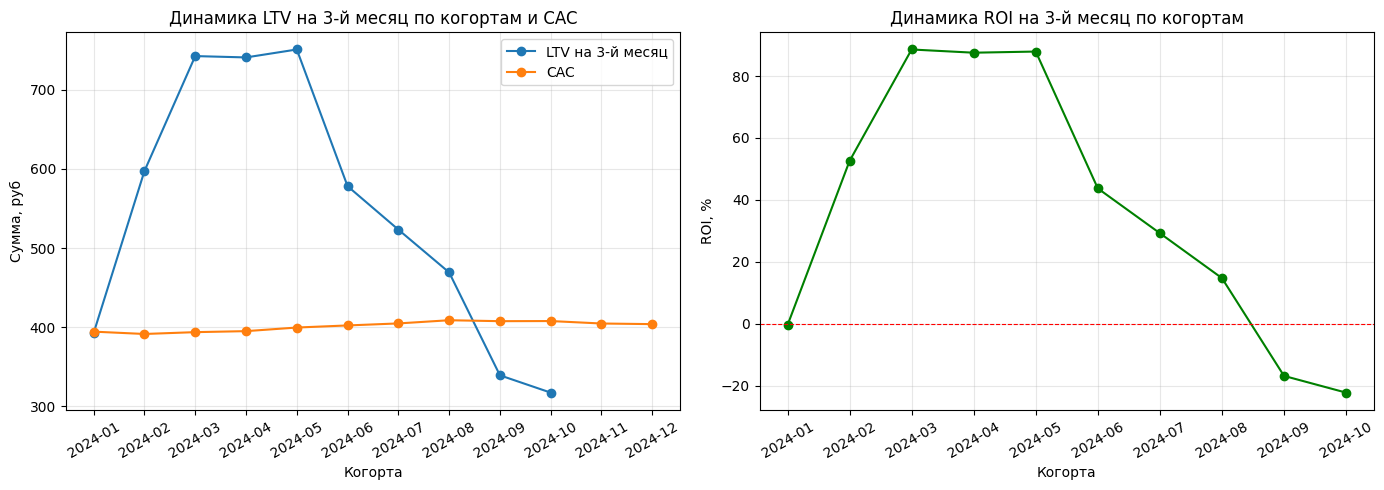

In [23]:
# ⚠️ LTV[2]  - это LTV за 3 месяц, CAC хранится в cac_series 

# собираем датафрейм и считаем ROI
third_m = pd.DataFrame({'LTV': LTV[2], 'CAC': cac_series})
third_m['ROI'] = (third_m['LTV'] - third_m['CAC']) * 100 / third_m['CAC']

# преобразуем в строки для красивых меток
third_m.index = third_m.index.strftime('%Y-%m')

# ------------------------------------------------------------------------------
# строим графики
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# LTV_CAC
ax[0].plot(third_m.index, third_m['LTV'], marker='o', label='LTV на 3-й месяц')
ax[0].plot(third_m.index, third_m['CAC'], marker='o', label='CAC')
ax[0].set_title('Динамика LTV на 3-й месяц по когортам и CAC')
ax[0].set_xlabel('Когорта')
ax[0].set_ylabel('Сумма, руб')
ax[0].legend()
ax[0].grid(alpha=0.3)
ax[0].tick_params(axis='x', rotation=30)

# ROI
ax[1].plot(third_m.index, third_m['ROI'], marker='o', color='green')
ax[1].axhline(0, color='red', linestyle='--', linewidth=0.8)
ax[1].set_title('Динамика ROI на 3-й месяц по когортам')
ax[1].set_xlabel('Когорта')
ax[1].set_ylabel('ROI, %')
ax[1].grid(alpha=0.3)
ax[1].tick_params(axis='x', rotation=30)

plt.tight_layout()
plt.show()

# display(Markdown(third_m.to_markdown()))


**LTV на 3-й месяц и CAC**
-  Графики наглядно подтверждают падение качества когорт. LTV на 3-й месяц падает с ~750 руб. до ~340 руб., в то  
время как CAC остается стабильным (~400 руб.).
-  Сентябрьская когорта — первая, которая не окупилась на 3-й месяц (LTV < CAC).

**ROI на 3-й месяц**
- ROI весенних когорт достигал ~90%, у августовской он всего ~15%, а у сентябрьской уже -17%.

## Выводы по этапам 2 и 3


**Revenue**

**⚠️ С конца лета и до конца года недельная выручка упала в 5.5 раз (~550k → 100k)** 🤔


---

**Stickiness**  
- Вовлеченность пользователей упала с 10.4%  до 7.6% (то есть на 27%) c апреля по декабрь. 

**Retention Rate**  
- удержание на второй месяц упало вдвое с января (35%) по ноябрь (19%) 
- на 4 месяц во всех когортах остается менее 10% платящих пользователей.

**CR в заказ**  
- Снижение CR в заказ с ~30% до ~20% во втором полугодии (с августа)

**ROI и Payback period**  
Эффективность маркетинга резко упала в середине года. Новые пользователи перестали окупать затраты на свое привлечение.
- у летних когорт (июнь-август) - срок окупаемости вырос до 2 месяцев
- когорты, начиная с сентября вообще не успели окупиться за время наблюдений

Снижение stickiness, CR и retention является основной причиной снижения выручки. Бизнес не только привлекает менее  
вовлеченную аудиторию, которая плохо переходит в статус покупателей, но и не может удержать платящих. Как следствие  
к концу года затраты на маркетинг перестали окупаться. **Если ROI весенних когорт на 3-й месяц достигал ~90%, то у  
сентябрьской он уже был отрицательным (-17%).**


## 4. Поиск инсайтов, точек роста и сегментация


На предыдущем этапе мы выяснили, что падение общей выручки связано со снижением качестве аудитории. Это проявилось в  
ухудшении ключевых показателей:
- **stickiness**
- **retention**
- **CR**
- **ROI** 


Чтобы найти причины ухудшения метрик, проанализируем данные в разрезе ключевых сегментов. 
1. Сначала оценим эффективность каналов привлечения с помощью юнит-экономики (CAC, LTV, ROI). 
2. Затем изучим воронку пользовательского пути, чтобы найти этапы с наибольшими потерями. 
3. После этого проанализируем retention по сегментам, чтобы определить, какие из них привлекают наиболее и наименее  
лояльных клиентов.



### Эффективность каналов привлечения по сегментам

#### CAC и новые пользователи по каналам

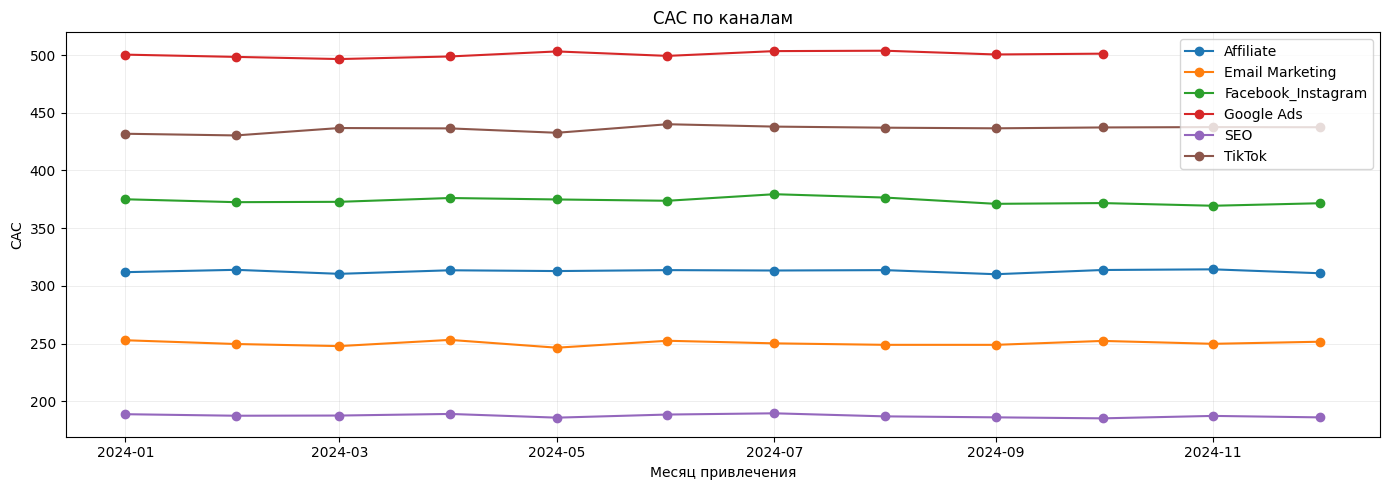

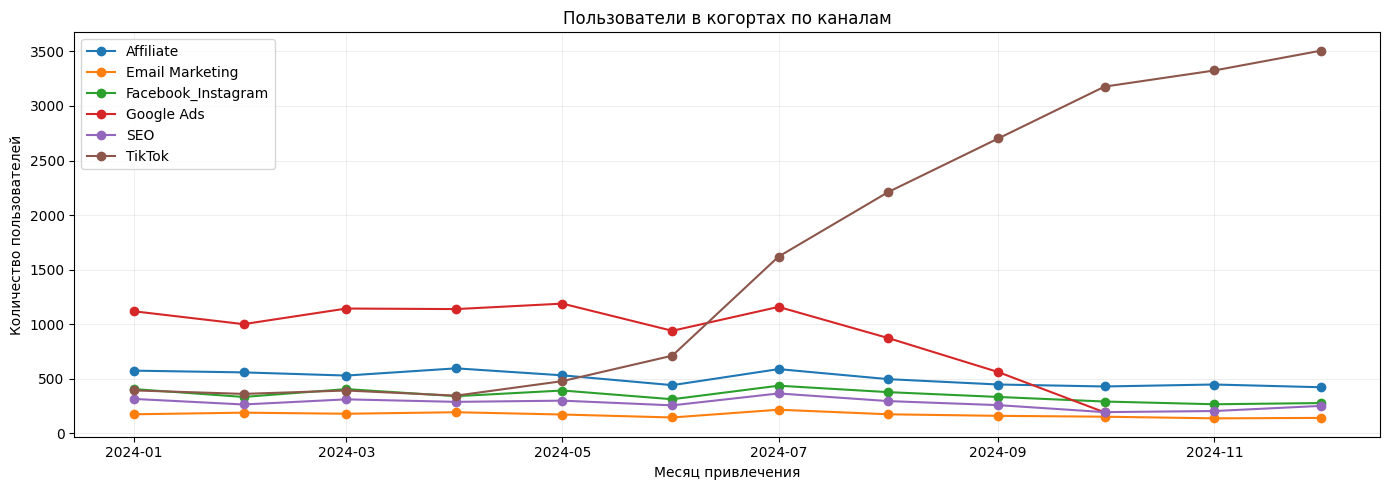

In [24]:
# для удобства
users, campaigns = ds['users'], ds['campaign_costs'].copy()
# переименуем столбец чтобы упростить себе жизнь
campaigns = campaigns.rename(columns={'spend_month': 'cohort_month'})

# параметры группировки
roi_segments = ['cohort_month', 'acq_channel']

# считаем
CAC = (
    users
    .groupby(roi_segments)['user_id']
    .nunique()
    .reset_index(name = 'user_cnt')
    .merge(
        campaigns.groupby(roi_segments)['budget'].sum().reset_index(),  
        on=roi_segments
    )
)

CAC['cac_ch'] = CAC['budget'] / CAC['user_cnt']

# ------------------------------------------------------------------------------
# строим графики

def plot_metric(CAC, channels, metric, ylabel, title):
    plt.figure(figsize=(14, 5))
    for ch in channels:
        ch_data = CAC[CAC['acq_channel'] == ch]
        plt.plot(ch_data['cohort_month'], ch_data[metric], marker='o', label=ch)
    plt.title(title)
    plt.xlabel('Месяц привлечения')
    plt.ylabel(ylabel)
    plt.grid(alpha=0.3, linewidth=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

channels = CAC['acq_channel'].unique()
plot_metric(CAC, channels, 'cac_ch', 'CAC', 'CAC по каналам')
plot_metric(CAC, channels, 'user_cnt', 'Количество пользователей', 
            'Пользователи в когортах по каналам')

# display(Markdown(CAC.to_markdown()))

**CAC по каналам**
- метрика остается очень стабильной по всем каналам привлечения на протяжении всего года. Отличается только уровень  
затрат.

**новые пользователи** 
- канал **TikTok** показывает взрывной рост аудитории во второй половине года. Если в июне около 700 новых пользователей, 
то в июле уже в 2 раз больше (~1600), а к концу года в декабре и вовсе в 5 раз (3500)
- канал **Google Ads** напротив начал привлекать немного меньше начиная с августа. С 1100 в июле до 200 в октябре. Далее  
и вовсе значения отсутствуют.
- остальные каналы очень стабильно по привлечению и находятся в диапазоне от 120 (Email marketing) до ~500 (Affiliate)


Таким образом, мы нашли наиболее вероятный источник всех проблем, обнаруженных в верхнеуровневом анализе. Взрывной рост  
трафика из **TikTok**, начавшийся в июле, совпадает по времени с падением stickiness, retention, CR и ROI Поскольку  
затраты на привлечение (CAC) стабильны по всем каналам в том числе и по каналу TikTok, это приводит к  пропорциональному 
росту расходов на канал в 5 раз. Бизнесу следует приостановить или кардинально пересмотреть кампании в TikTok. 

С другой стороны мы видим снижение привлекаемой аудитории канала **Google Ads**. Следует разобраться в причинах. 
Возможно данный вид рекламы больше не работает в стране из-за геополитки. Если эта гипотеза неверна, необходимо  
постараться восстановить прежние значения.

#### LTV/CAC и ROI по каналам на 3 месяц "жизни"

In [ ]:
# переименуем чтобы упростить себе жизнь
orders = orders.rename(columns={'first_act_mon': 'cohort_month'})

# добавим канал привлечения
orders_ch = orders.merge(users[['user_id', 'acq_channel']], 
                         how = 'left', on = 'user_id')    
    
# считаем накопленную выручку 
pivot_gmv = orders_ch.pivot_table(
    index=roi_segments,  #⚠️ ['cohort_month', 'acq_channel']
    columns='n_period',
    values='total_price',
    aggfunc='sum'
)
cum_gmv_flat = pivot_gmv.cumsum(axis=1).reset_index()

# преобразуем period в datetime
cum_gmv_flat['cohort_month'] = cum_gmv_flat['cohort_month'].dt.to_timestamp()

# размеры каналов когорт объединяем с накоп. выручкой 
merged_data = (
    users
    .groupby(roi_segments)['user_id']
    .nunique()
    .reset_index(name='cohort_ch_size')
    .merge(cum_gmv_flat,  on=roi_segments)
)

# колонки с доступными периодами
n_period_cols = [col for col in merged_data.columns if isinstance(col, int)]

# колонки делим выручку на размер когорты
ltv_data = merged_data[n_period_cols].div(merged_data['cohort_ch_size'], axis=0).mul(0.05)

# 6. Добавляем обратно колонки для индекса и устанавливаем их как MultiIndex
LTV_ch = pd.concat([merged_data[roi_segments], ltv_data], axis=1)
LTV_ch = LTV_ch.set_index(roi_segments)


# display(Markdown(LTV_ch.to_markdown()))

# ------------------------------------------------------------------------------

# LTV на 3-й месяц
ltv_3m = LTV_ch[2].reset_index(name='LTV_3m')

# CAC
cac_data = CAC[[*roi_segments, 'cac_ch']].rename(columns={'cac_ch': 'CAC'})

# объединяем
metrics_df = pd.merge(ltv_3m, cac_data, on=roi_segments)

# считаем ROI на 3-й месяц
metrics_df['ROI_3m'] = (metrics_df['LTV_3m'] - metrics_df['CAC']) * 100 / metrics_df['CAC']


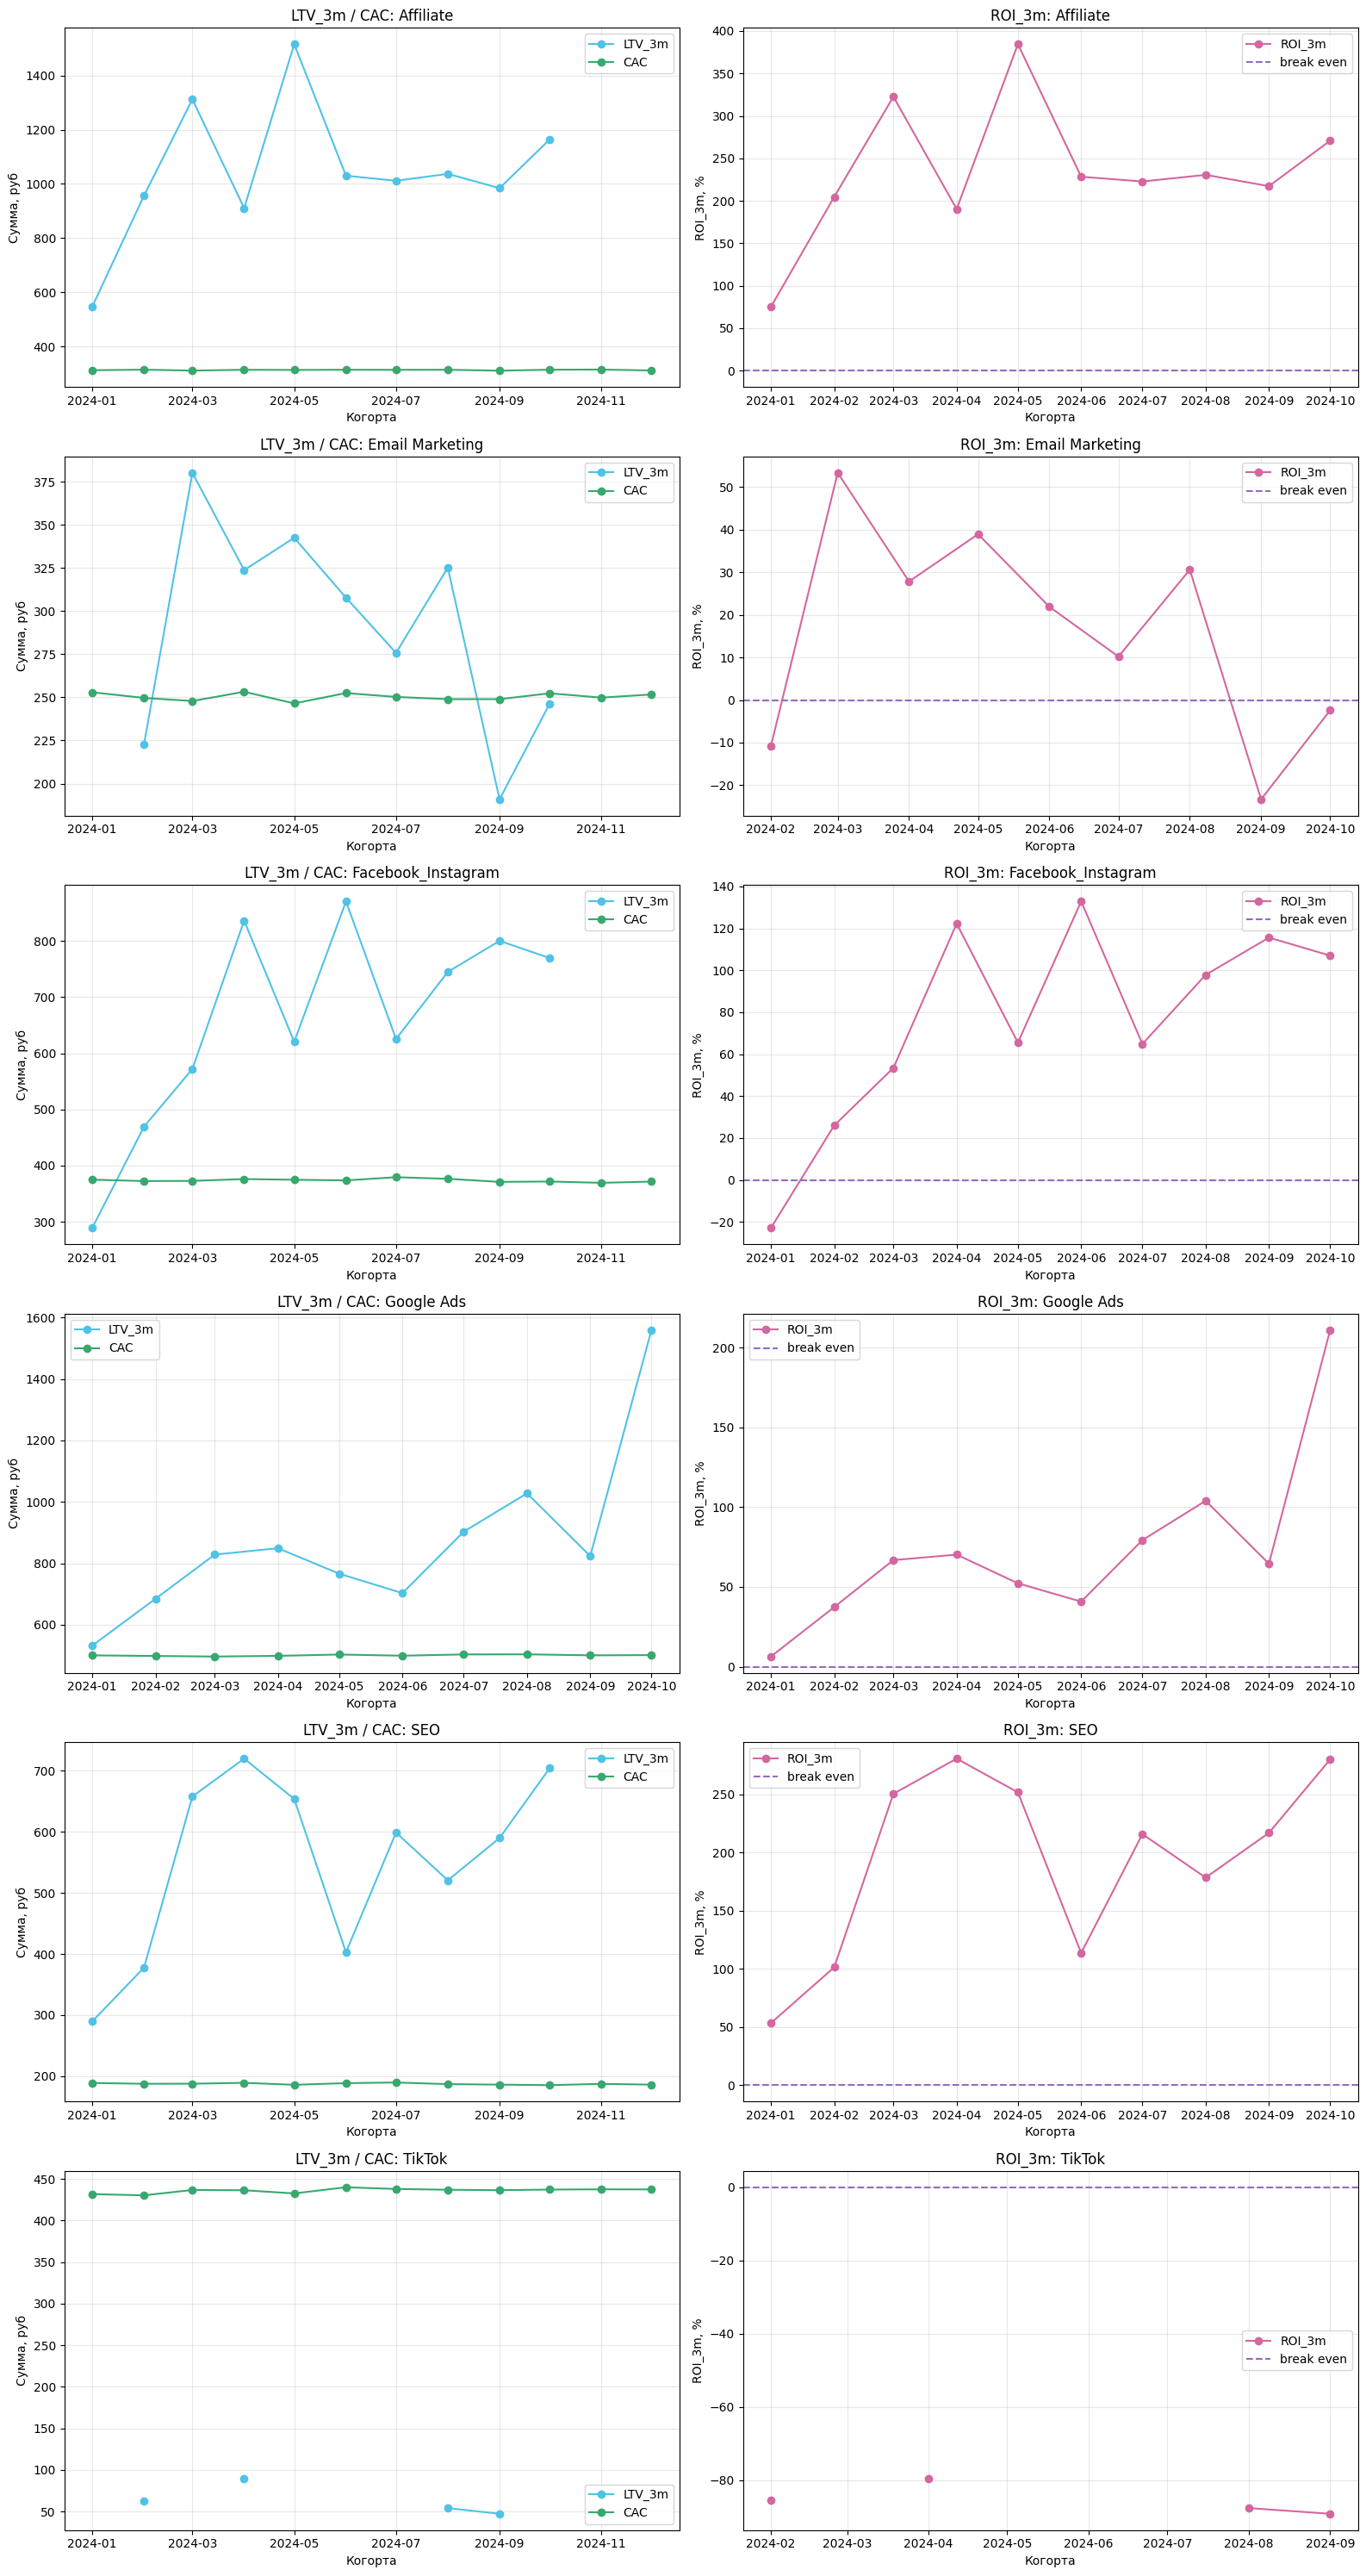

In [48]:
# функция для отрисовки графиков (LTV / CAC и ROI) для одного канала
def plot_channel_metrics(ax_ltv, ax_roi, df, channel, met):
    # выбираем данные для канала
    ch = df[df['acq_channel'] == channel].copy()
    coh = ch['cohort_month']
    
    # LTV и CAC
    ax_ltv.plot(coh, ch[met[0]], marker='o', label=met[0], color=pal[1])
    ax_ltv.plot(coh, ch[met[1]], marker='o', label=met[1], color=pal[2])
    ax_ltv.set_title(f'{met[0]} / {met[1]}: {channel}')
    ax_ltv.set_xlabel('Когорта')
    ax_ltv.set_ylabel('Сумма, руб')
    ax_ltv.legend()
    ax_ltv.grid(alpha=0.3)
    ax_ltv.tick_params(axis='x', rotation=0)

    # ROI
    ax_roi.plot(coh, ch[met[2]], marker='o', color=pal[3], label=met[2])
    ax_roi.axhline(0, color=pal[4], linestyle='--', label='break even')
    ax_roi.set_title(f'{met[2]}: {channel}')    
    ax_roi.set_xlabel('Когорта')
    ax_roi.set_ylabel(f'{met[2]}, %')
    ax_roi.legend()
    ax_roi.grid(alpha=0.3)
    ax_roi.tick_params(axis='x', rotation=0)

    # вывод для отладки
    # display(Markdown(ch.to_markdown()))


# собираем метрики
ltv_3m = LTV_ch[2].reset_index(name='LTV_3m')
cac_data = CAC[['cohort_month', 'acq_channel', 'cac_ch']].rename(columns={'cac_ch': 'CAC'})
metrics_df = pd.merge(ltv_3m, cac_data, on=['cohort_month', 'acq_channel'])
metrics_df['ROI_3m'] = (metrics_df['LTV_3m'] - metrics_df['CAC']) * 100 / metrics_df['CAC']

# создаем сетку и вызываем функцию в цикле
channels = metrics_df['acq_channel'].unique()
fig, axs = plt.subplots(len(channels), 2, figsize=(16, len(channels) * 5))

met_names = ['LTV_3m', 'CAC', 'ROI_3m']

for i, channel in enumerate(channels):
    plot_channel_metrics(axs[i][0], axs[i][1], metrics_df, channel, met_names)

plt.tight_layout()
plt.show()


**Все или почти все когорты стабильных каналов успешно окупаются.**  

**Affiliate**, **SEO**
- каналы Affiliate и SEO показывают самый высокий ROI (часто >200%).

**Facebook_Instagram** 
- в целом окупается, но январская когорта оказалась убыточной на горизонте 3 месяцев. Вероятно позже она окупиться.

**Google Ads**  
- самый дорогой, но также стабильно прибыльный канал. Всплеск доходности Google Ads в конце периода  
наблюдений может быть связан со снижением количества привлекаемых пользователей как мы видели ранее. По-видимому  
снизилась доля именно нецелевого трафика.

**Email Marketing**
- 3 когорты из 10 не отбили затраты:
    - февральской и октябрьской когортам "не хватило" 10% и менее 
    - а сентябрьская не дотянула чуть более 22%
- 6 окупивших затраты в плюсе в среднем около 25%
- канал нестабильный и может нести риски убытков. Требуются держать под контролем расходы на этот канал

**TikTok**
- ⚠️ "полный провал" по всем когортам - ни одна из когорт даже близко не окупилась
- из 10 когорт по 6 вообще нет данных - это значит что в них никто так ничего и не приобрел за 3 месяца
- у остальных 4 когорт ROI находится в убытке в среднем на ~83%. В остальных соответственно убыток составляет 100%.


**Теперь отчетливо видно что канал TikTok с ростом трафика в 5 раз и крайне низкой (отрицательной) окупаемостью (ROI)  
является вероятно основной причиной снижения общей выручки.**

### Воронка пользовательского пути по сегментам
⚠️**ATTENTION** bar_label не работает из-за старой версии Matplotlib на платформе. **SOLVED**❗


**Воронку можно построить по следующим типам событий**

| №  | Описание                 | События                           |
|-----|-------------------------|----------------------------------|
| 1   | Поиск/Просмотр каталога/Промо | search + category_view + promo_view |
| 2   | Просмотр товара           | product_view                     |
| 3   | Добавление в корзину      | add_to_cart                     |
| 4   | Начало оформления         | checkout_start                  |
| 5   | Успешная покупка         | checkout_complete               |



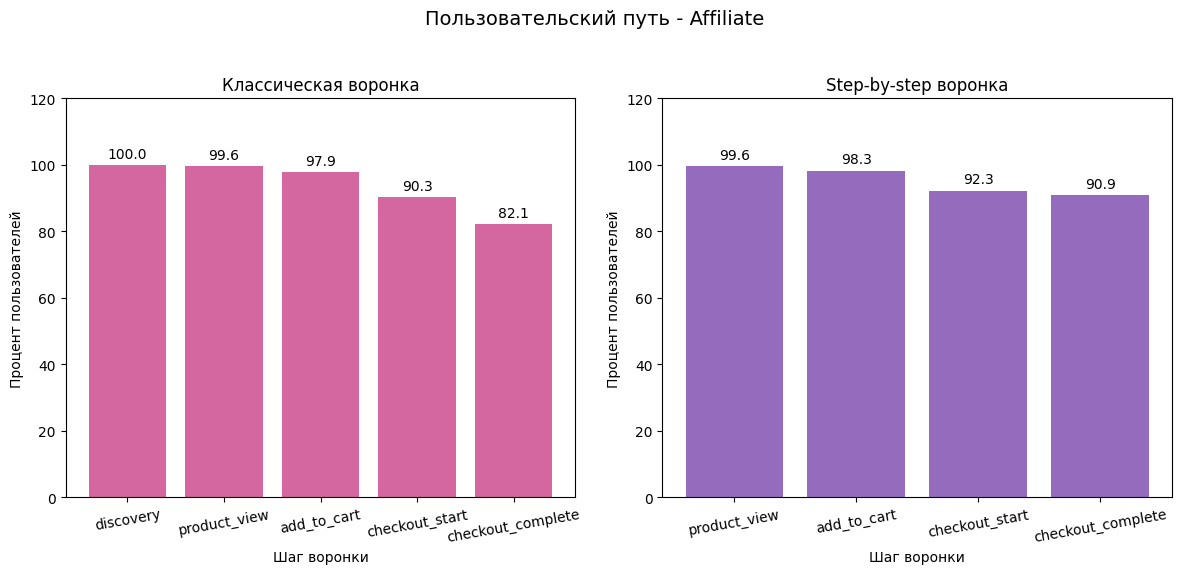

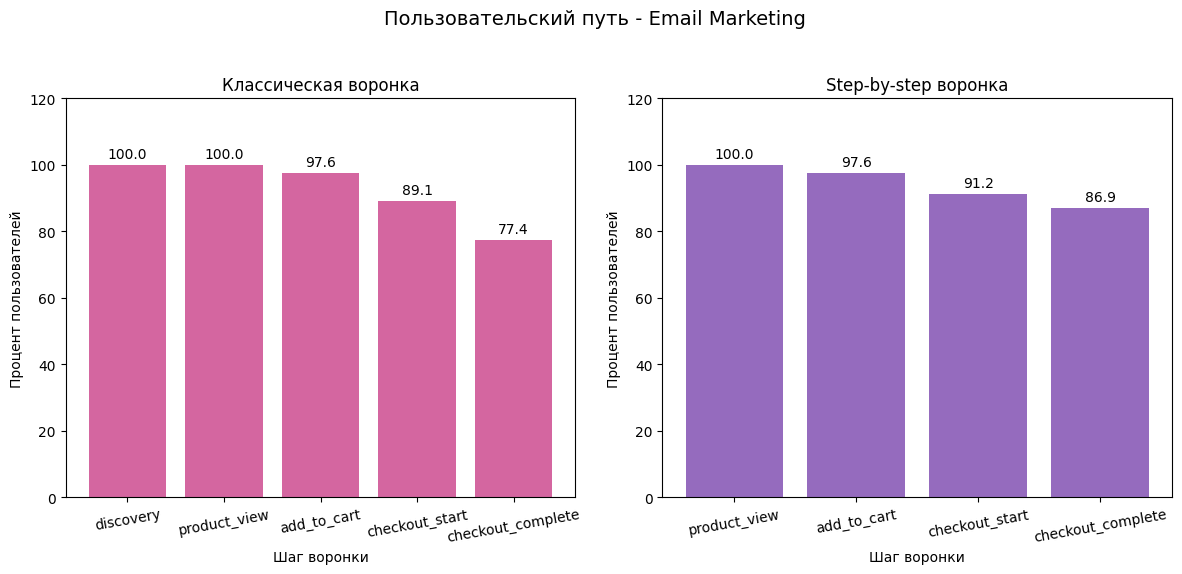

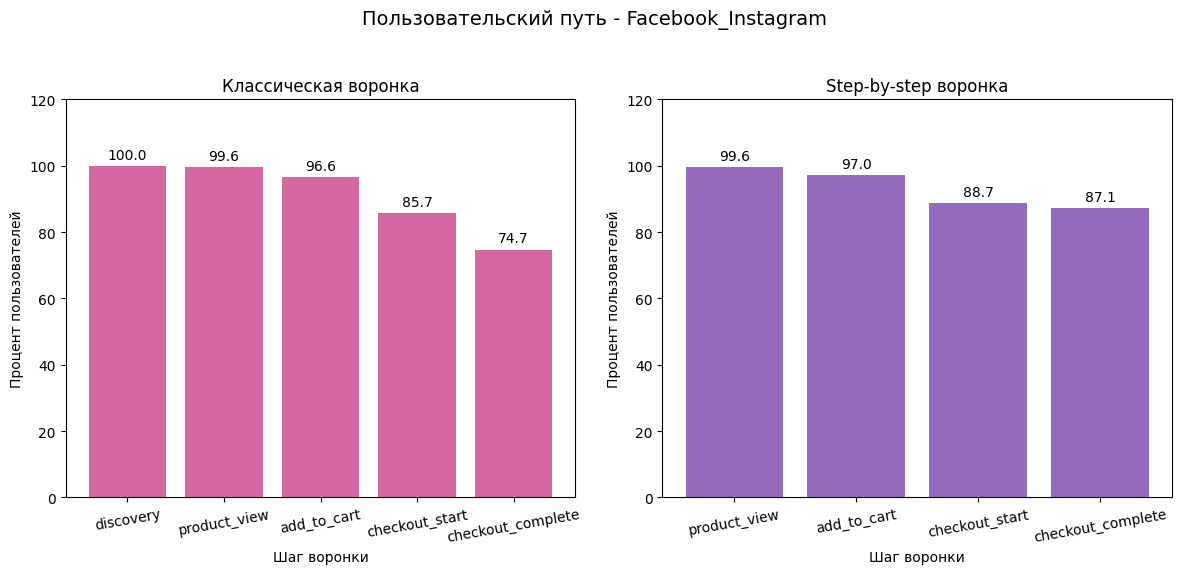

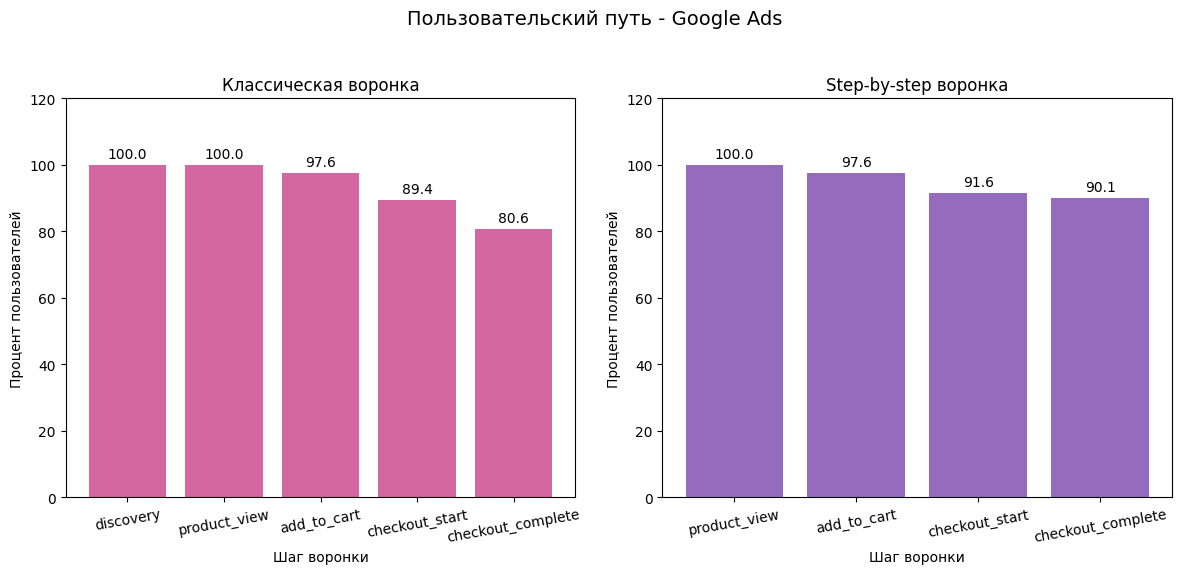

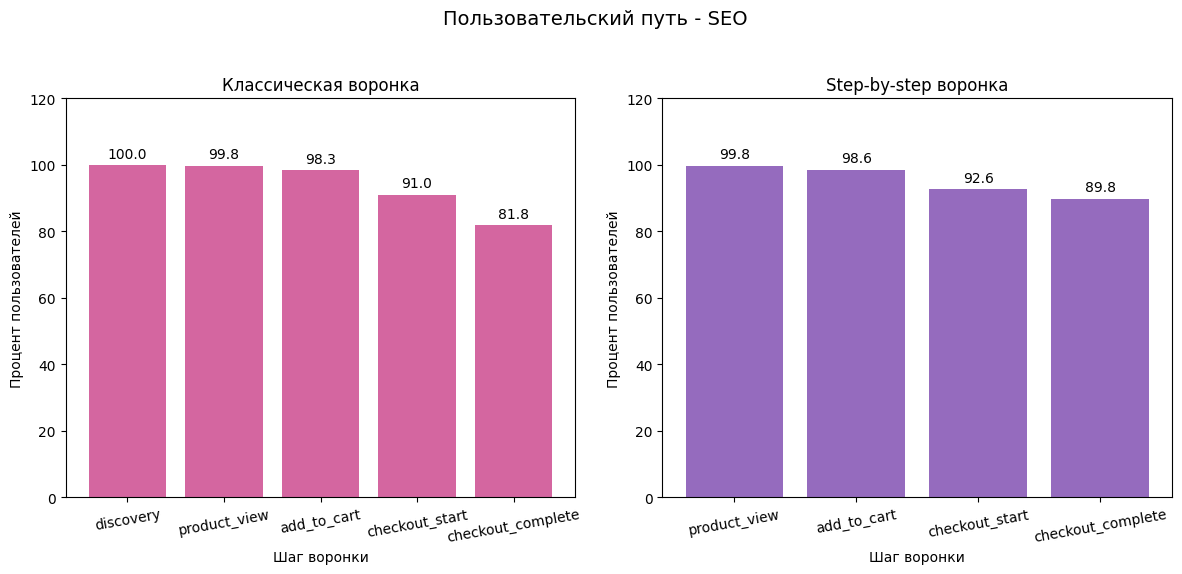

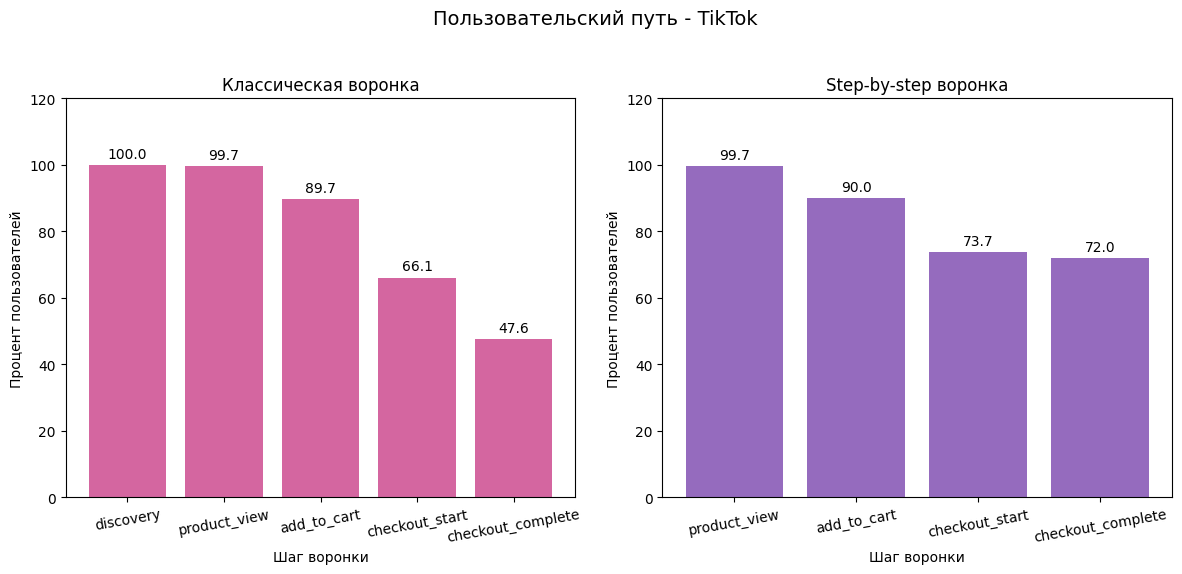

In [ ]:
funnel_events = ds['events'].copy()

# объединим события в одно
funnel_events['event_type'] = (
    funnel_events
    ['event_type']
    .replace({  
        'search': 'discovery',
        'category_view': 'discovery',
        'promo_view': 'discovery',
    })
)

# шаги воронки 
fun_steps = ['discovery', 'product_view', 'add_to_cart', 
             'checkout_start', 'checkout_complete']

# сортируем, убираем время у даты, фильтруем по шагам
fun_step_data = (
    funnel_events
    .sort_values(['user_id', 'event_date'])
    .assign(event_date_norm=lambda df: df['event_date'].dt.normalize())
    .loc[lambda df: df['event_type'].isin(fun_steps)]
    .merge(users[['user_id', 'acq_channel']], how='left', on='user_id')
)

# ------------------------------------------------------------------------------
# функция для расчета и графика классич. и пошаговой воронки по одному сегменту
# ------------------------------------------------------------------------------
def calc_plot_funnel (df, seg_filed, segmnets, steps,  etype, uid, colors):
    # пользовательский путь м.б.нелинейный - поэтому воронку  
    # считаем, фильтруя пользователей пришедших с предшествующего шага
    
    for seg in segmnets:
        seg_data = df[df[seg_filed]==seg] 
        prev_step_ids = set(seg_data[uid])
        step_ids = {}
        for step in steps:
            this_step_ids  = set(
                seg_data[
                    (seg_data[etype] == step) &
                    (seg_data[uid].isin(prev_step_ids))
                ][uid]
            )
            step_ids[step] = len(this_step_ids)
            prev_step_ids = this_step_ids
        
        fun_df = pd.DataFrame(step_ids.items(), columns=['step', 'usr_cnt'])
        
        # классич. и step by step воронки
        fun_df['cr_from_first'] = fun_df.loc[:, 'usr_cnt'] *100 / \
                                    fun_df.loc[0, 'usr_cnt'] 
        fun_df['cr_from_prev'] = fun_df.loc[:, 'usr_cnt'] *100 / \
                                    fun_df.shift(1)['usr_cnt']

        
        # ----------------------------------------------------------------------
        # строим графики
        fig, ax = plt.subplots(1, 2, figsize=(12, 6))
        fig.suptitle(f'Пользовательский путь - {seg}', fontsize=14)

        for i, (met,title) in enumerate([('cr_from_first', 'Классическая'),
                                        ('cr_from_prev', 'Step-by-step')]):
            bars = ax[i].bar(fun_df['step'], fun_df[met], color=colors[i])
            
            ax[i].set_title(f'{title} воронка')
            ax[i].set_xlabel('Шаг воронки')
            ax[i].set_ylabel('Процент пользователей')
            
            #⚠️❗❗❗bar_label не работает из-за старой версии Matplotlib в Практикуме.
            # Я не знаю что с этим делать.             
            
            ax[i].bar_label(bars, fmt='%.1f', padding=3) 
            ax[i].tick_params(axis='x', labelrotation=10)
            ax[i].set_ylim(0, 120)
        
        # plt.tight_layout()
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()
        
        
        # print(f'Пользовательский путь ({seg})')
        # print(fun_df)


# ------------------------------------------------------------------------------
# считаем воронки и строим графики  
calc_plot_funnel(fun_step_data, 'acq_channel', channels, fun_steps,  
                 'event_type', 'user_id', pal[3:])

**Affiliate, Email Marketing, Facebook_Instagram, Google Ads, SEO**

Каналы ведут себя схожим образом: 
- на шаге просмотра товара практически нет просадки 
- на шаге добавления в корзину конверсия просаживается на несколько процентов 
- на каждом последующем шаге (начало и завершение оформления заказа) метрика падает в среднем примерно по 10%

**TikTok**
- уже на этапе добавления товара в корзину конверсия проседает на 10%  
- ⚠️ На последующих шагах (checkout_start и checkout_complete) потери очень большие - около 26-28% на каждом.

Таким образом, взрывной рост числа новых пользователей в канале TikTok действительно обусловлен привлечением нецелевого  
и плохо конвертируемого трафика.

#### Сегментация по типу устройств (device)

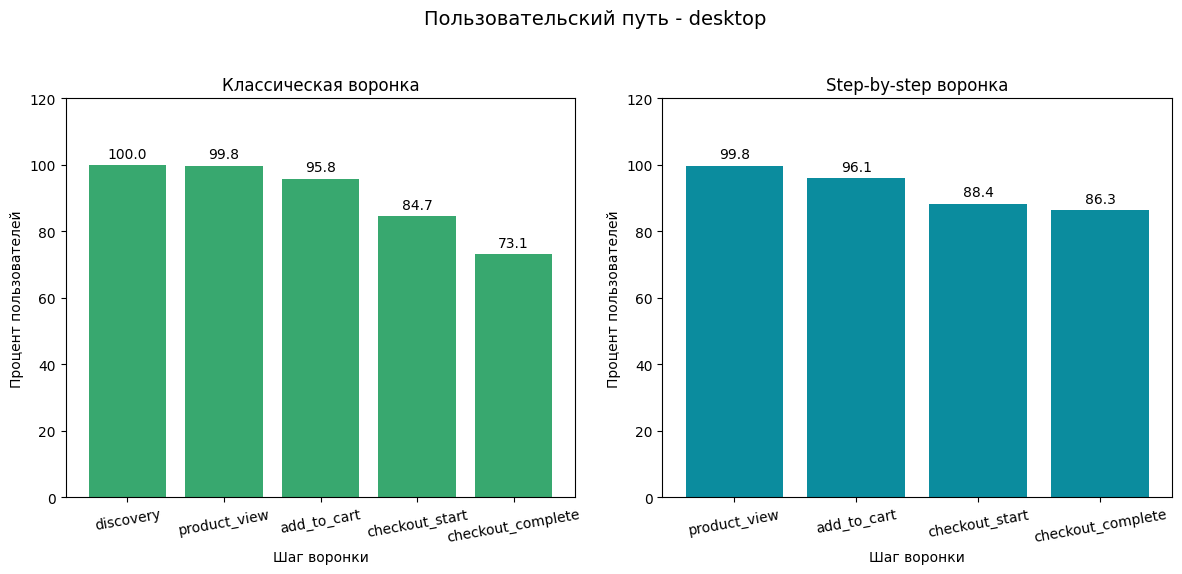

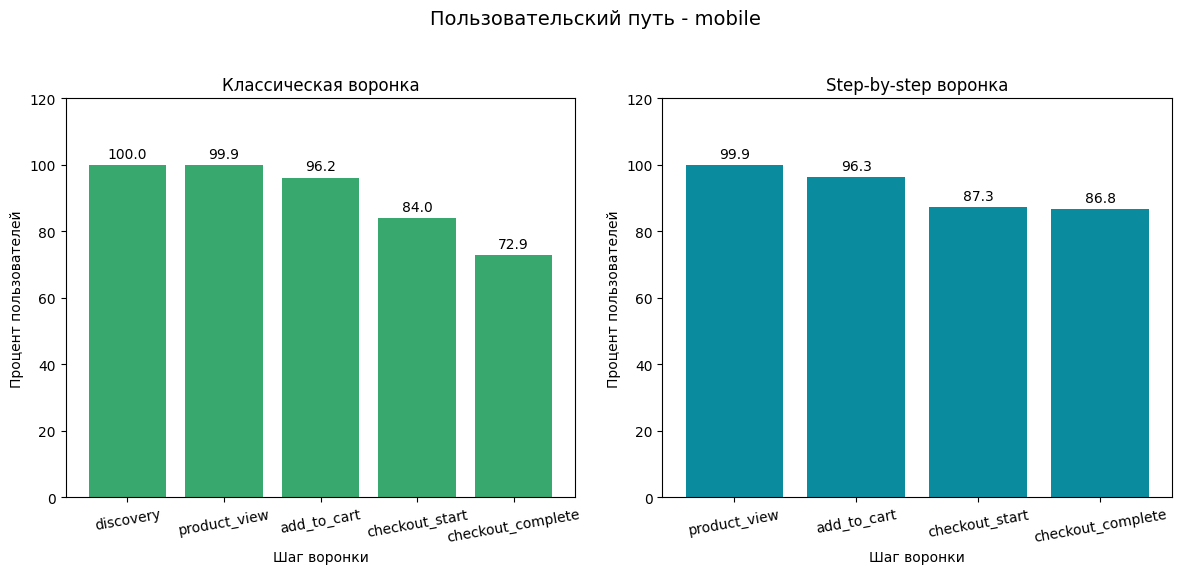

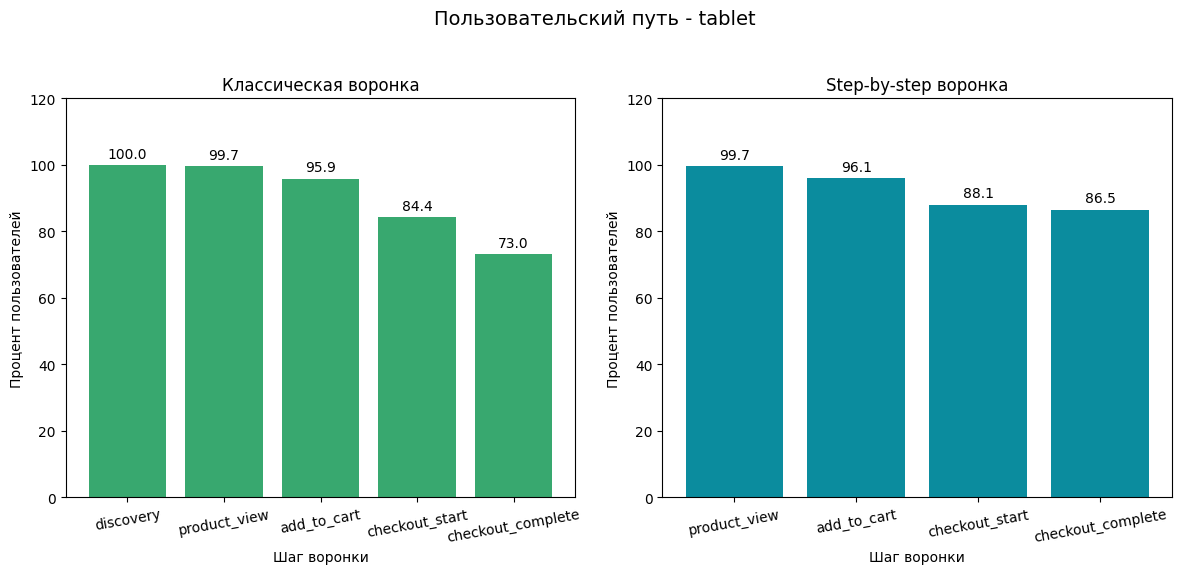

In [28]:
# сегменты
devices = fun_step_data['device'].unique()

# считаем воронки и строим графики
calc_plot_funnel(fun_step_data, 'device', devices, fun_steps,  
                 'event_type', 'user_id', [pal[2], pal[5]])


**desktop, mobile, tablet**
во всех 3 сегментах одна и та же картина 
- около 96% пользователей искавших товар помещает его в корзину 
- около 84% начинает оформлять заказ 
- и только около 73% доходит до завершения оформления

Проблема падения конверсии не связана с конкретным типом устройства.

#### Retention по сегментам

In [29]:
# функция для расчета и построения графика retention по каналам
def calc_plot_retention(df, label, date_col, segments, seg_field, params,show=False):

    # создаем сетку
    rows = int(np.ceil(len(segments)/2))
    _, axs = plt.subplots(rows, 2, figsize=(18, 5*rows), sharex=False, sharey=True)
    flat_axs = axs.flatten()

    # цикл по каналам и осям
    for i, seg in enumerate(segments):
        ax = flat_axs[i]
        ch_data = df[df[seg_field] == seg]
        
        # считаем retention
        _, retention = calc_retention(ch_data, date_col)
        
        # строим график
        if show:
            display(Markdown(f'**{seg}**'))
            display(Markdown(retention.mul(100).round(2).to_markdown()))
        sns.heatmap(retention, ax=ax, **params)
        ax.set_title(seg)

    # общее оформление
    plt.suptitle(f'Retention по {label} - в разрезе {seg_field}', fontsize=18)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
    display(Markdown(f'---'))


#### Retention по покупкам 

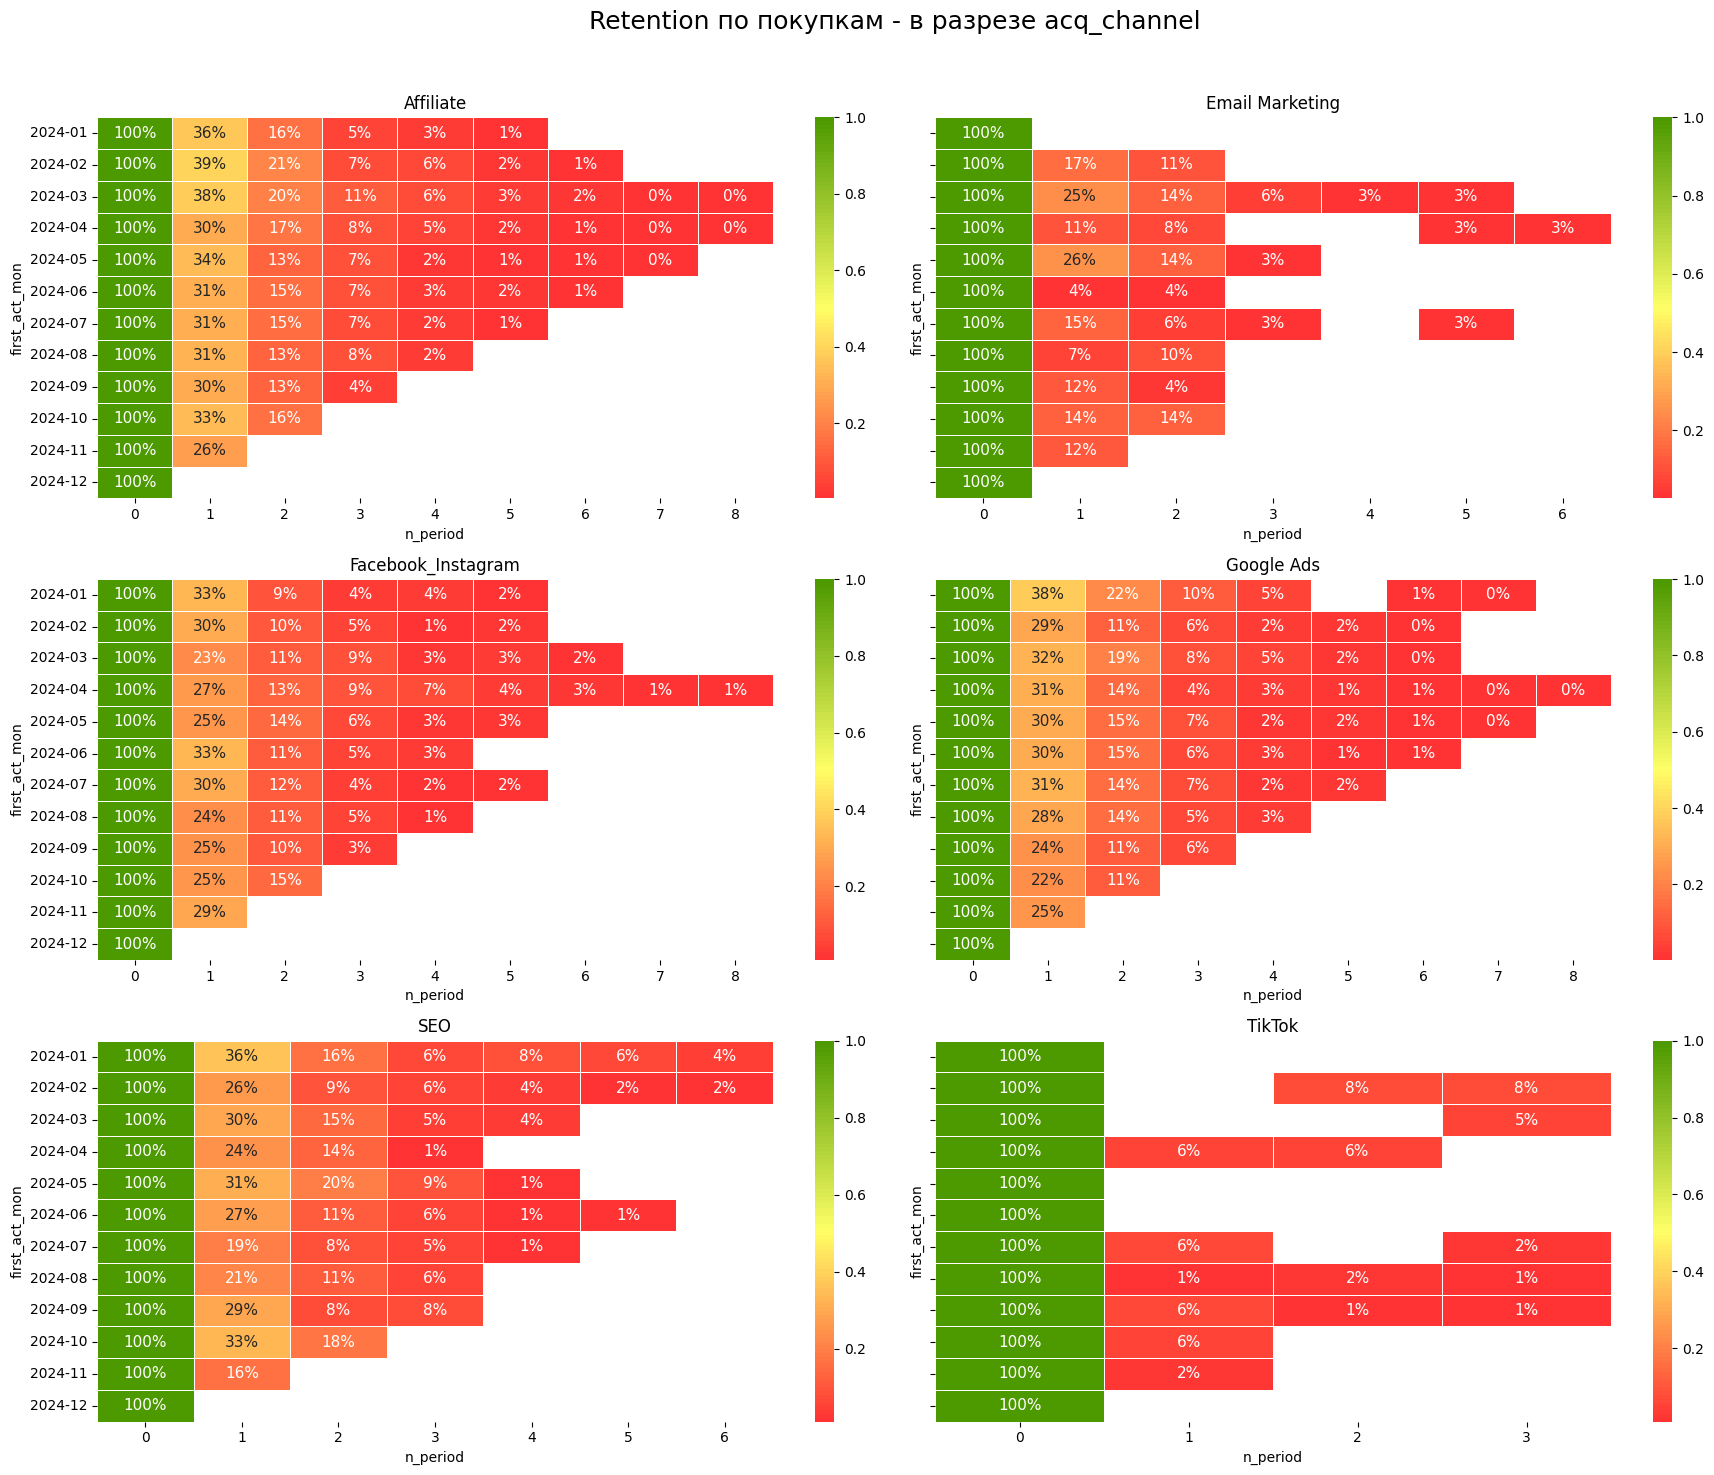

---

In [ ]:
# добавляем информацию о канале
orders_ch = (
    ds['orders']
    .merge(
        users[['user_id', 'acq_channel']],
        how='left', on='user_id'
    )
)

# считаем и строим графики
calc_plot_retention(orders_ch, 'покупкам', 'order_date',
                    channels, 'acq_channel', heatmap_pct_params)

**Retention по покупкам в разрезе каналов**  
**Все каналы (кроме TikTok)** 
- схожая картина - резкое падение удержания после первого месяца и постепенное затухание в последующие.

**TikTok**
- удержание практически нулевое - пользователи не возвращаются за повторными покупками, что полностью подтверждается  
наши предыдущими выводами.

**Пропуски в данных**  
- говорят о крайней нестабильности - в некоторые месяцы у когорт не было ни одной повторной покупки.

Различий по каналам не обнаружено. За исключением TikTok, но основная проблема все же в том, что общий Retention  
по продукту очень низкий для всех источников трафика. Это может говорить о проблемах в самом продукте

#### Retention по сессиям 

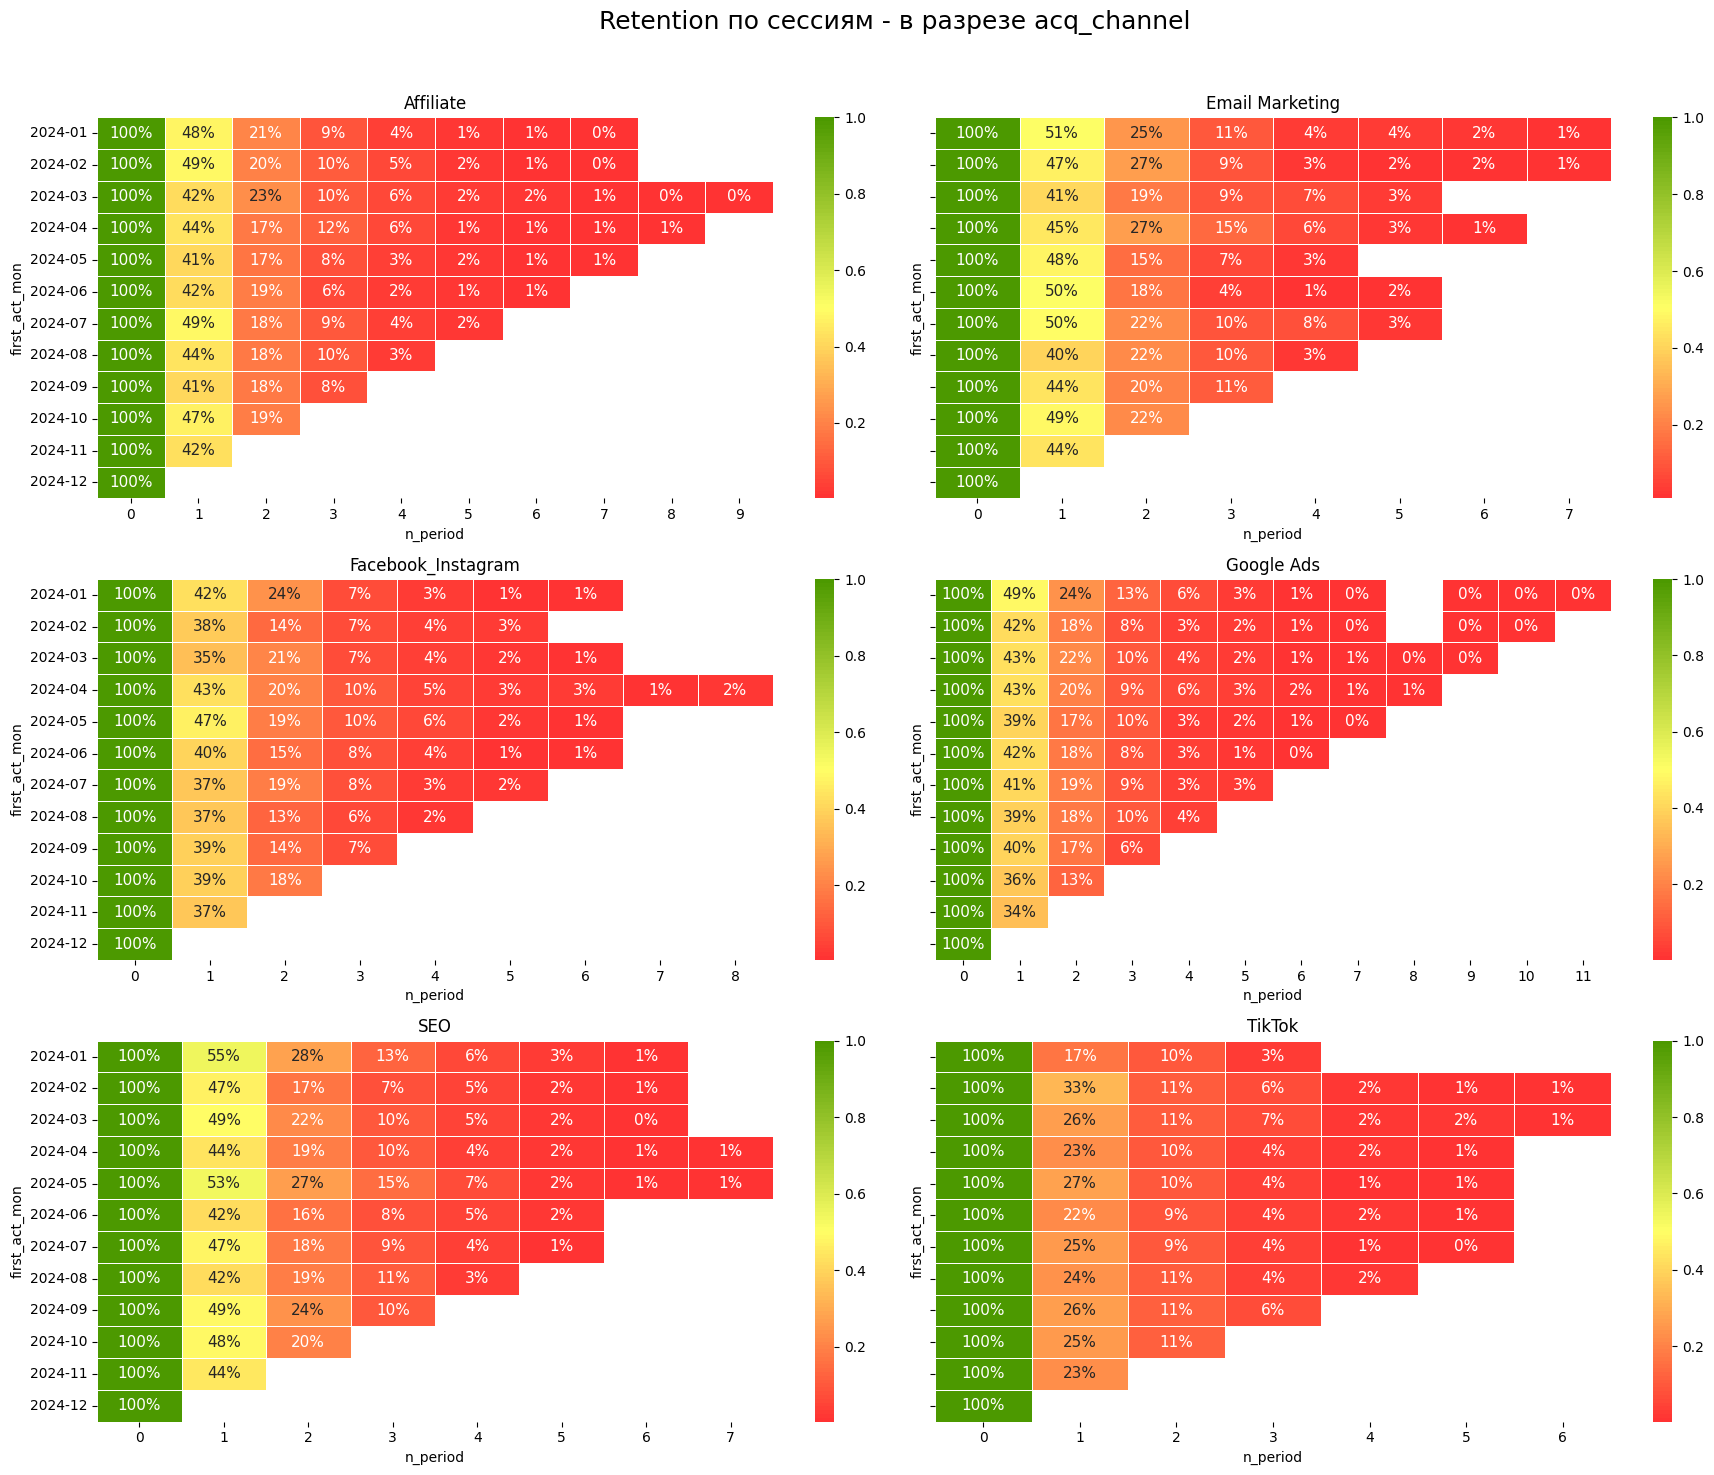

---

In [ ]:
# добавляем информацию о канале
sessions_ch = (
    ds['sessions']
    .merge(
        users[['user_id', 'acq_channel']], 
        how='left', on='user_id'
    )
)

# считаем и строим графики
calc_plot_retention(sessions_ch, 'сессиям', 'session_start', 
                    channels, 'acq_channel', heatmap_pct_params)


**Retention по сессиям**
- как и в случае с покупками, все "стабильные" каналы показывают схожую динамику. Удержание на второй месяц колеблется  
в диапазоне 40%-50%, что существенно выше, чем удержание по покупкам.
- у большинства каналов наблюдается небольшое снижение retention для более поздних когорт. Наиболее заметно падение у  
канала Google Ads (с 48% до 34%).
- удержание по сессиям  в TikTok вдвое ниже чем у других каналов (в среднем ~25% на второй месяц).


**Общая картина по retention**
- за исключением TikTok, все каналы показывают схожую динамику. Это говорит о том, что низкий retention - это,  
скорее всего, проблема самого продукта, а не конкретного канала.
- удержание по сессиям (~40-50% на 2-й месяц) значительно выше, чем по покупкам (~20-35%). Пользователи заходят, но не  
покупают: 
- у TikTok удержание и по покупкам, и по сессиям крайне низкое, что подтверждает предположение о нецелевом трафике.
- у большинства каналов наблюдается небольшое снижение retention по сессиям для более поздних когорт.

## Выводы по этапу 4

**TikTok**
- падение общей выручки и ROI напрямую связано со взрывным ростом (в 5.5 раз) трафика во втором полугодии
- при этом канал поставляет нецелевую аудиторию, у которой:
    - нулевое удержание по покупкам.
    - вдвое худшее удержание по сессиям.
    - крайне низкая конверсия в воронке (потери около 27% на шагах оформления).
    - ROI лежит в дапазоне от -85% до -100%  

**Google Ads**
- во втором полугодии объем трафика из Google Ads значительно упал. Однако качество оставшейся аудитории резко выросло  
ROI октябрьской когорты превысил 200%.

**Общая проблема продукта**
- даже у стабильных каналов общий retention по покупкам очень низкий. Пользователи заходят на сайт, но ничего не покупают.  
Это говорит о возможных проблемах в самом продукте.
- анализ по устройствам не выявил проблем.

Бизнес совершил ошибку, масштабировав убыточный канал TikTok. Это наряду с невысоким удержанием (в покупку) привело к   
резкому падению всех ключевых метрик.

**Гипотеза 1** (на основе CAC, LTV и ROI по каналам):  
Если мы полностью отключим рекламные кампании в TikTok и направим его бюджет на более прибыльные каналы, то общий ROI  
значительно вырастет, потому что мы уберем главный источник убытков.

**Гипотеза 2** (на основе ROI и объема привлечения по каналу Google Ads):  
Если масштабировать успешные (октябрьские) кампании в Google Ads, то можно увеличить количество качественных  
пользователей без значительного падения ROI.

**Гипотеза 3** (на основе большого различия retention по сессиям и покупкам):  
Если внедрить программу лояльности для пользователей, совершивших первую покупку, retention по покупкам вырастет.

## 5. Подготовка эксперимента и подведение его результатов

Получите вводную информацию для выполнения этого этапа у ревьюера после успешного завершения предыдущих шагов.

# Новые вводные (после этапа 4)

Команда продукта рассмотрела твои гипотезы и на основании этого решила влиять на конверсию при помощи финансовых стимуляций. Так как ситуация со снижением выручки срочная и безотлагательная, пока ты продолжал изучать данные, они подключили другого аналитика для подготовки дизайн документа, но само проведение эксперимента на тебе. При формировании выводов допиши рекомендации по итогам теста и, если необходимо, опиши проблемы, присутствующие в эксперименте.

## Новые данные:

```python
events_AB
orders_AB
sessions_AB
users_AB
```

## Результаты сплита лежат в таблице:

```python
AB_split_users
```

* user_id – id клиента
* group – группа, в которую попал клиент

# Дизайн эксперимента:

Бонус на первую покупку для пользователей TikTok

## 1. Контекст и цель эксперимента

- **Бизнес-контекст:** Команда продукта запускает эксперимент, направленный на повышение конверсии среди пользователей, привлечённых через канал TikTok. Для стимулирования первой покупки пользователям будет предоставлен бонус на первую покупку.  
- **Цель:** Проверить, влияет ли предоставление бонуса на первую покупку на конверсию и выручку среди пользователей TikTok.  
- **Гипотеза:** Предоставление бонуса на первую покупку новым пользователям, привлеченным через TikTok, приведет к увеличению конверсии в первую покупку

---

## 2. Формат эксперимента

- **Тип эксперимента:** Сплит-роллинг (rolling split)  
- **Канал:** Только пользователи, пришедшие с TikTok  
- **Группы:**  
  - **Контрольная (A):** пользователи TikTok без бонуса  
  - **Тестовая (B):** пользователи TikTok с бонусом на первую покупку  
- **Распределение:** Равномерное распределение новых пользователей TikTok между группами по дате регистрации  
- **Период проведения:** 3 недели (фиксировано)

---

## 3. Ключевые метрики

### Основная метрика

- **Конверсия в первую покупку** — доля пользователей, зарегистрировавшихся с TikTok и совершивших первую покупку  
  - *Цель:* увеличить конверсию с помощью бонуса  
  - *Критерий успеха:* статистически значимый рост конверсии в тестовой группе

### Вспомогательные метрики

- **ARPU** (средняя выручка на пользователя TikTok)  
- **ARPPU** (средняя выручка на покупателя TikTok)  
- **AOV** (средний чек TikTok)

### Барьерная метрика

- **Общая выручка от пользователей TikTok**

---

## 4. Размеры групп и запуск

- **Целевая аудитория:** только пользователи TikTok  
- **Размеры групп:** определяются по фактическому трафику TikTok за период эксперимента  
- **Комментарий:** запуск без предварительного расчёта мощности и MDE из-за срочности задачи


In [ ]:
# загрузим данные
base_url = 'https://some_url'
secret_path = "secret_path_"
base_names = ['events_AB', 'orders_AB', 'sessions_AB', 'users_AB', 'AB_split_users']

# колонки с датами 
ab_dates_cols = {
    'orders_AB': ['order_date', 'order_week', 'order_month'],
    'sessions_AB': ['session_start', 'session_week', 'session_month'],
    'users_AB': ['registration_date', 'cohort_week', 'cohort_month'],
    'events_AB': ['event_date', 'event_week', 'event_month']
}

# собираем датасеты в словарь
abt = { 
    d: pd.read_csv(
        f'{base_url}{secret_path}{d}.csv', 
        parse_dates = ab_dates_cols.get(d, [])
    ) for d in base_names 
}


# ⚠️ parse_dates не сработал для некоторых полей
# ValueError: time data "2025-01-01 00:31:20" doesn't match format 
# "%Y-%m-%d %H:%M:%S.%f", at position 18009.

# поправим вручную
for key, col in [('orders_AB', 'order_date'), 
                 ('sessions_AB', 'session_start')]:
    abt[key][col] = pd.to_datetime(abt[key][col], format='mixed')
    print(f'даты в поле {key}[{col}] имеют тип - {abt[key][col].dtype}')



даты в поле orders_AB[order_date] имеют тип - datetime64[ns]
даты в поле sessions_AB[session_start] имеют тип - datetime64[ns]


'Размер группы A: 1503'

'Размер группы B: 1465'

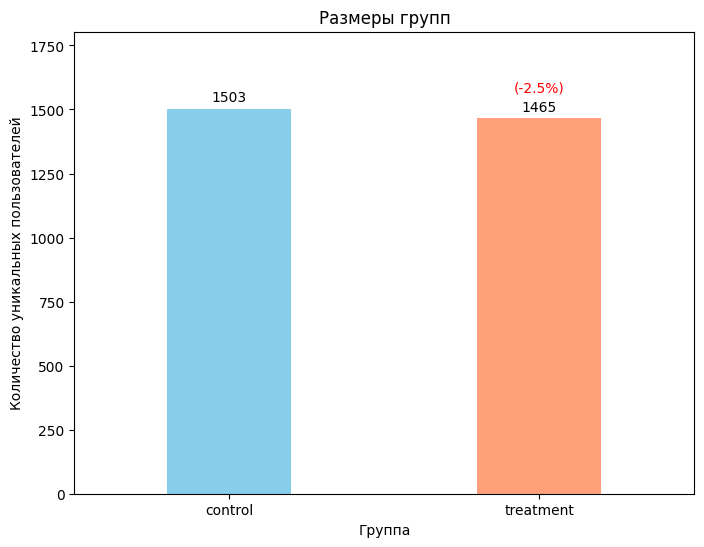

In [33]:
# переобозначим для удобства
su = abt['AB_split_users']

group_size = su.groupby('group')['user_id'].nunique()
display(f"Размер группы A: {group_size['control']}", 
        f"Размер группы B: {group_size['treatment']}")

plot_group_comparison_bar(
    data=group_size, 
    title='Размеры групп', 
    ylabel='Количество уникальных пользователей', 
    colors=(color_A, color_B)
)

 **Небольшие расхождения в размерах выборок допустимы, но для надежности, проверим значимость различий**

 - применим для этого z-тест для одной пропорции.
 - будем сравнивать соотношение успехов (польз. в тестовой группе) ко всем событиям (все пользователи) с гипотетической  
 величиной 50% (равномерное распределение) 

In [34]:
# общее число испытаний
n_total = len(su)

# число "успехов" (пользователей в тестовой группе) и "неудач"
n_treatment = len(su[su['group'] == 'treatment'])
n_control = n_total - n_treatment

# z-тест
stat, p_value = proportions_ztest(
    count=n_treatment,
    nobs=n_total,
    value=0.5,
    alternative='two-sided'
)

# вывод
alpha = 0.05
res = ('<', 'ЗНАЧИМО') if p_value < alpha else ('>=', 'не значимы')

print(f"""
Проверка сплитования:
Доля Control:   {n_control / n_total:.2%} ({n_control} / {n_total})
Доля Treatment: {n_treatment / n_total:.2%} ({n_treatment} / {n_total})
P-value:        {p_value:.4f} {res[0]} {alpha}. Различие со сплитом 50/50 статистически {res[1]}.
""")



Проверка сплитования:
Доля Control:   50.64% (1503 / 2968)
Доля Treatment: 49.36% (1465 / 2968)
P-value:        0.4854 >= 0.05. Различие со сплитом 50/50 статистически не значимы.



Таким образом различия в размерах тестовой и контрольной выборок **статистически не значимы**

**Проверим теперь нет ли пересечений групп**

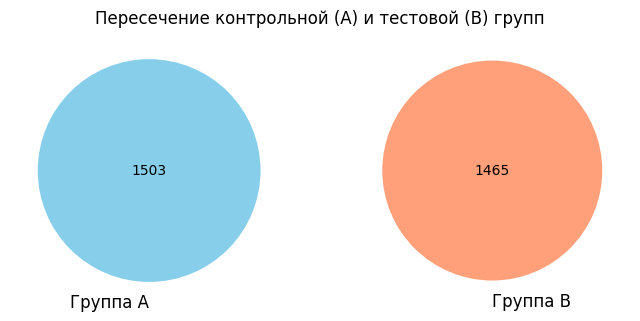

In [35]:
# Получаем уникальных пользователей
users_a = set(su[su['group']=='control']['user_id'])
users_b = set(su[su['group']=='treatment']['user_id'])

# Строим диаграмму Венна
plt.figure(figsize=(8,5))
v = venn2([users_a, users_b], set_labels=('Группа A', 'Группа B'), set_colors=(color_A, color_B))
# убираем прозрачность
[patch.set_alpha(1.0) for patch in v.patches if patch]
    
      
plt.title('Пересечение контрольной (A) и тестовой (B) групп')
plt.show()

**Пересечений групп нет**

#### Конверсия в первую покупку
- Найдем даты проведения эксперимента и отфильтруем по ним датасеты

In [36]:
# объединяем пользователей со сплитом   
ab_users = pd.merge(abt['AB_split_users'], abt['users_AB'], on='user_id')

# Находим дату начала и конца эксперимента
start_date = ab_users['registration_date'].min()
end_date = ab_users['registration_date'].max()

print(f"Эксперимент начался: {start_date}")
print(f"Эксперимент закончился: {end_date}")
print(f"Длительность: {(end_date - start_date).days} дней")

Эксперимент начался: 2025-01-01 00:05:00
Эксперимент закончился: 2025-01-26 23:41:00
Длительность: 25 дней


In [37]:
# получаем ID пользователей, участвующих в тесте
ab_uids = su['user_id'].unique()

# переобозначим
orders_ab = abt['orders_AB']
sessions_ab = abt['sessions_AB']
events_ab = abt['events_AB']

# фильтруем таблицы
orders_ab = orders_ab[
    (orders_ab['user_id'].isin(ab_uids)) &
    (orders_ab['order_date'].between(start_date, end_date))
].copy()

# фильтруем сессии
sessions_ab = sessions_ab[
    (sessions_ab['user_id'].isin(ab_uids)) &
    (sessions_ab['session_start'].between(start_date, end_date))
].copy()

# фильтруем события
events_ab = events_ab[
    (events_ab['user_id'].isin(ab_uids)) &
    (events_ab['event_date'].between(start_date, end_date))
].copy()

print(f"Заказов в эксперименте: {len(orders_ab)}")
print(f"Сессий в эксперименте: {len(sessions_ab)}")

Заказов в эксперименте: 255


Сессий в эксперименте: 811


In [38]:
# покупатели
buyers_ids = set(orders_ab['user_id'])

# добавляем к пользователям
ab_users['converted'] = ab_users['user_id'].isin(buyers_ids).astype(int)


cr_data = ab_users.groupby('group').agg(
   users_cnt = ('user_id', 'nunique'),
   payers_cnt = ('converted', 'sum')
)

cr_data['cr'] = cr_data['payers_cnt'] / cr_data['users_cnt']

print(cr_data)

           users_cnt  payers_cnt        cr
group                                     
control         1503          16  0.010645
treatment       1465         110  0.075085


**Коверсия в тестовой группе (treatment) получилась в ~7.1 раз больше чем контроле (7.5% vs 1.06%)**
- теперь нужно проверить значимость полученного результата


**Проверка гипотезы о равенстве долей (конверсий)**

- **H₀ (Нулевая гипотеза):** Конверсии в контрольной и тестовой группах **равны**.
- **H₁ (Альтернативная гипотеза):** Конверсии в контрольной и тестовой группах **статистически значимо отличаются**.

In [39]:
# Извлекаем числа для z-теста
# Количество успехов (плательщиков)
m_a = cr_data.loc['control', 'payers_cnt']
m_b = cr_data.loc['treatment', 'payers_cnt']

# Количество испытаний (всех пользователей)
n_a = cr_data.loc['control', 'users_cnt']
n_b = cr_data.loc['treatment', 'users_cnt']

# Рассчитываем доли успехов
p_a, p_b = m_a / n_a, m_b / n_b

# ------------------------------------------------------------------------------
alpha = 0.05

stat_ztest, p_val_ztest = proportions_ztest(
    [m_a, m_b], # Успехи (плательщики)
    [n_a, n_b], # Испытания (все пользователи)
    alternative='two-sided'
)

# ------------------------------------------------------------------------------
# Выводим результат
res = ('<', 'ОТВЕРГАЕМ') if p_val_ztest < alpha else ('>=', 'не отвергаем')

print(f"""
Размер выборки (Контроль): {n_a}
Размер выборки (Тест):    {n_b}

Конверсия в контроле: {p_a:.2%} ({m_a} / {n_a})
Конверсия в тесте:    {p_b:.2%} ({m_b} / {n_b})

P-value: {p_val_ztest:.4f} {res[0]} {alpha}
Нулевую гипотезу {res[1]}. Различия статистически ЗНАЧИМЫ.
"""
)


Размер выборки (Контроль): 1503
Размер выборки (Тест):    1465

Конверсия в контроле: 1.06% (16 / 1503)
Конверсия в тесте:    7.51% (110 / 1465)

P-value: 0.0000 < 0.05
Нулевую гипотезу ОТВЕРГАЕМ. Различия статистически ЗНАЧИМЫ.



**Отвергаем нулевую гипотерзу. Различия статистически ЗНАЧИМЫ. (P-value: 0.0000 < 0.05)**

Таким образом конверсия в первую покупку действительно улучшается благодаря маркетинговой стимуляции в 7.1 раз.  
Однако необходимо проверить как себя ведут остальные вспомогательные и барьерные метрики. Нужно убедиться что внедрение  
не ухудшает остальных метрик. 

---

#### Вспомогательные метрики ARPU и ARPPU

In [40]:
# считаем выручку и кол-во покупателей
rp_ab = (
    orders_ab
    .merge(su, how='left', on='user_id')
    .groupby('group')
    .agg(
        revenue = ('total_price', 'sum'),   
        payers_cnt = ('user_id', 'nunique')   
    )
    .reset_index()
)

# не забываем что бизнес зарабатывает с комиссии
rp_ab['revenue'] = rp_ab['revenue']*0.05 

rp_ab['users_cnt'] = np.where(rp_ab['group'] == 'control', n_a, n_b)
# считаем метрики
rp_ab['arpu'] = rp_ab['revenue'] / rp_ab['users_cnt']
rp_ab['arppu'] = rp_ab['revenue'] / rp_ab['payers_cnt']

rp_ab['arpu_pct'] = rp_ab['arpu'].pct_change() *100
rp_ab['arppu_pct'] = rp_ab['arppu'].pct_change() *100
print(rp_ab)


       group      revenue  payers_cnt  users_cnt        arpu        arppu  \
0    control   18918.6450          16       1503   12.587255  1182.415313   
1  treatment  192279.8515         110       1465  131.249045  1747.998650   

     arpu_pct  arppu_pct  
0         NaN        NaN  
1  942.713763  47.832883  


**ARPU**
- средняя выручка на пользователя выросла почти в 9.5 (942%).  Рост огромный, но это было вполне ожидаемо, поскольку и   
конверсия выросла в 7 раз.

**ARPPU** 
- средняя выручка на покупателя подросла значительно скромнее, но только в сравненни с взрывным увеличением ARPU - 47.8% 
- сам по себе результат очень хороший.

Бонус не только увеличил количество покупателей (конверсию), но и значительно увеличил сумму, которую они тратят.

---

#### Вспомогательные метрики AOV и ARPO

In [41]:
# стоимость каждого чека + добавляем группу
checks_df = (
    orders_ab
    .groupby('order_id')
    .agg(
        check=('total_price', 'sum'),
        user_id=('user_id', 'first') 
    )
    .merge(su, how='left', on='user_id')
)

# AOV
aov_arpo = (
    checks_df
    .groupby('group')['check']
    .mean()
    .reset_index()
    .rename(columns={'check': 'AOV'})
)

# ARPO
aov_arpo['ARPO'] = aov_arpo['AOV'] * 0.05
aov_arpo['AOV_pct']  = aov_arpo['AOV'].pct_change() *100

print(aov_arpo)

       group          AOV        ARPO   AOV_pct
0    control  15765.53750  788.276875       NaN
1  treatment  16647.60619  832.380310  5.594917


**AOV**  
- средний чек вырос на 5.6% с 15.7k руб до 16.6k руб

**ARPO**
- средняя выручка с заказа выросла с 788 руб до 832 руб. 
- приращение в процентах то же самое - поскольку метрика просто представляют долю от среднего чека

Такии образом, выросли не только конверсия в покупку и выручка на пользователя, но и средний чек.


#### Барьерная метрика - общая выручка канала TikTok

- остается проверить что не просела барьерная метрика, но мы уже ее посчитали ранее


In [42]:
rp_ab['revenue']
rp_ab['revenue_pct'] = rp_ab['revenue'].pct_change()*100

print(rp_ab[['group','revenue', 'revenue_pct']])

       group      revenue  revenue_pct
0    control   18918.6450          NaN
1  treatment  192279.8515   916.351073


**Revenue**
- общая выручка выросла более чем в 9 раз (+916%)

Барьерная метрика не просела, а даже наоборот выросла в разы, что является очень хорошим результатом.

## Выводы

**Бизнес столкнулся с падением выручки в 5.5 раз.**

Как удалось выяснить в результате проведенного исследования, выручка упала из-за масштабирования неэффективного канала  
TikTok. Канал показывал низкую конверсию теряя до 27% на этапах оформления заказа, практически нулевое удержание и  
убыточную окупаемость (-85% -100%).

Для решения проблемы был проведен A/B тест с проверкой гипотезы роста конверсии в первую покупку при внедрении бонуса  
за первую покупку. 

Эксперимент оказался крайне успешным и привел к росту ключевой и вспомогательных метрик
- **CR в первую покупку - рост в 7.1 раз (p_value = 0.00000 < 0.05 - различия стат. значимы**)
- **ARPU - рост почти в 9.5 (942%)**
- **AOV - средний чек вырос на 5.6% до 16.6k руб**

Барьерная метрика также не просела и даже показала взрывной рост 
- **Revenue - рост на 916%**


Бизнесу **рекомендуеся внедрить** бонусную программу на всех пользователей TikTok. Следует проследить за удержанием   
тестовой группы в следующие несколько месяцев, чтобы убедиться, что привлеченные бонусом пользователи продолжают  
пользоваться продуктом когда маркетинговых программ уже нет. 

Также возможно, стоит провести A/B тест с разными размерами бонуса, чтобы найти оптимальное соотношение между конверсией  
и затратами.
